In [2]:
import sqlite3
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [3]:
RT_LIMIT_LOWER = 3000  # RT range in the database
RT_LIMIT_UPPER = 3600
RT_BASE_PEAK_WIDTH_SECS = 30.0  # assumption about base peak width in RT
RT_FRAGMENT_EVENT_DELTA_SECS = 3.5  # use this window for constraining RT to focus on the fragmentation event
MS1_CE = 10

In [4]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}-denoised".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
BASE_MAXQUANT_TXT_DIR = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt'
ALLPEPTIDES_FILENAME = '{}/allPeptides.txt'.format(BASE_MAXQUANT_TXT_DIR)
PASEF_MSMS_SCANS_FILENAME = '{}/pasefMsmsScans.txt'.format(BASE_MAXQUANT_TXT_DIR)

# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [5]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-3000-3600-denoised/HeLa_20KInt.sqlite'

In [6]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where collision_energy == {}".format(MS1_CE), db_conn)
ms2_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where collision_energy <> {}".format(MS1_CE), db_conn)
db_conn.close()

In [7]:
ms2_frame_properties_df[ms2_frame_properties_df.frame_id == 28077]

,frame_id,retention_time_secs
127,28077,3015.078925


In [8]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,27937,3000.034855
1,27948,3001.215839
2,27959,3002.398227
3,27970,3003.582723
4,27981,3004.765302


In [9]:
ms2_frame_properties_df.head()

,frame_id,retention_time_secs
0,27938,3000.140990
1,27939,3000.248039
2,27940,3000.354686
3,27941,3000.463820
4,27942,3000.570786


In [10]:
ms1_frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
ms1_frame_delay

1.1809843170835848

In [11]:
len(ms1_frame_properties_df)

508

In [12]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [13]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [14]:
# add-in the retention time for the isolation windows and filter out the window not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2) - 0.7
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2) + 0.7
isolation_window_df['wide_rt_lower'] = isolation_window_df.retention_time_secs - RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['wide_rt_upper'] = isolation_window_df.retention_time_secs + RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['fe_rt_lower'] = isolation_window_df.retention_time_secs - RT_FRAGMENT_EVENT_DELTA_SECS
isolation_window_df['fe_rt_upper'] = isolation_window_df.retention_time_secs + RT_FRAGMENT_EVENT_DELTA_SECS

In [15]:
isolation_window_df.to_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df_with_rt.pkl')

In [16]:
# filter out isolation windows that don't fit in the database subset we have loaded
isolation_window_df = isolation_window_df[(isolation_window_df.wide_rt_lower >= RT_LIMIT_LOWER) & (isolation_window_df.wide_rt_upper <= RT_LIMIT_UPPER)]

In [17]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,wide_rt_lower,wide_rt_upper,fe_rt_lower,fe_rt_upper
200320,28216,215,240,1186.725324,3.00000,93064,3030.015909,1184.525324,1188.925324,3000.015909,3060.015909,3026.515909,3033.515909
200321,28216,354,379,942.892922,3.00000,93055,3030.015909,940.692922,945.092922,3000.015909,3060.015909,3026.515909,3033.515909
200322,28216,423,448,871.841025,3.00000,93071,3030.015909,869.641025,874.041025,3000.015909,3060.015909,3026.515909,3033.515909
200323,28216,495,520,789.852032,2.89852,93069,3030.015909,787.702772,792.001292,3000.015909,3060.015909,3026.515909,3033.515909
200324,28216,560,585,689.250354,2.00000,93058,3030.015909,687.550354,690.950354,3000.015909,3060.015909,3026.515909,3033.515909


In [18]:
len(isolation_window_df)

43301

In [19]:
isolation_window_df.Precursor.nunique()

20027

In [20]:
isolation_window_df.sort_values(by=['Precursor']).tail(20)

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,wide_rt_lower,wide_rt_upper,fe_rt_lower,fe_rt_upper
243619,33241,716,741,612.977988,2.000000,113080,3569.959523,611.277988,614.677988,3539.959523,3599.959523,3566.459523,3573.459523
243610,33240,716,741,612.977988,2.000000,113080,3569.851127,611.277988,614.677988,3539.851127,3599.851127,3566.351127,3573.351127
243601,33238,716,741,612.977988,2.000000,113080,3569.639517,611.277988,614.677988,3539.639517,3599.639517,3566.139517,3573.139517
243598,33238,563,588,635.107977,2.000000,113081,3569.639517,633.407977,636.807977,3539.639517,3599.639517,3566.139517,3573.139517
243607,33240,563,588,635.107977,2.000000,113081,3569.851127,633.407977,636.807977,3539.851127,3599.851127,3566.351127,3573.351127
243599,33238,618,643,661.761363,2.000000,113082,3569.639517,660.061363,663.461363,3539.639517,3599.639517,3566.139517,3573.139517
243608,33240,618,643,661.761363,2.000000,113082,3569.851127,660.061363,663.461363,3539.851127,3599.851127,3566.351127,3573.351127
243611,33240,771,796,457.881052,2.000000,113083,3569.851127,456.181052,459.581052,3539.851127,3599.851127,3566.351127,3573.351127
243620,33241,771,796,457.881052,2.000000,113083,3569.959523,456.181052,459.581052,3539.959523,3599.959523,3566.459523,3573.459523
243602,33238,771,796,457.881052,2.000000,113083,3569.639517,456.181052,459.581052,3539.639517,3599.639517,3566.139517,3573.139517


In [21]:
for idx,group_df in isolation_window_df.groupby('Precursor'):
    print("precursor {} has {} frames".format(int(group_df.iloc[0].Precursor), len(group_df)))

precursor 93050 has 1 frames
precursor 93055 has 1 frames
precursor 93057 has 1 frames
precursor 93058 has 1 frames
precursor 93062 has 1 frames
precursor 93064 has 1 frames
precursor 93067 has 1 frames
precursor 93069 has 1 frames
precursor 93071 has 1 frames
precursor 93072 has 1 frames
precursor 93073 has 2 frames
precursor 93074 has 2 frames
precursor 93075 has 1 frames
precursor 93076 has 1 frames
precursor 93077 has 1 frames
precursor 93078 has 3 frames
precursor 93079 has 1 frames
precursor 93080 has 1 frames
precursor 93081 has 2 frames
precursor 93082 has 1 frames
precursor 93083 has 4 frames
precursor 93084 has 2 frames
precursor 93085 has 3 frames
precursor 93086 has 2 frames
precursor 93087 has 1 frames
precursor 93088 has 2 frames
precursor 93089 has 3 frames
precursor 93090 has 1 frames
precursor 93091 has 1 frames
precursor 93092 has 5 frames
precursor 93093 has 2 frames
precursor 93094 has 2 frames
precursor 93095 has 1 frames
precursor 93096 has 2 frames
precursor 9309

precursor 93579 has 1 frames
precursor 93580 has 1 frames
precursor 93581 has 4 frames
precursor 93582 has 6 frames
precursor 93583 has 5 frames
precursor 93584 has 3 frames
precursor 93585 has 3 frames
precursor 93586 has 1 frames
precursor 93587 has 1 frames
precursor 93588 has 1 frames
precursor 93589 has 3 frames
precursor 93590 has 3 frames
precursor 93591 has 1 frames
precursor 93592 has 1 frames
precursor 93593 has 1 frames
precursor 93594 has 1 frames
precursor 93595 has 3 frames
precursor 93596 has 1 frames
precursor 93597 has 1 frames
precursor 93598 has 1 frames
precursor 93599 has 3 frames
precursor 93600 has 3 frames
precursor 93601 has 2 frames
precursor 93602 has 2 frames
precursor 93603 has 4 frames
precursor 93604 has 2 frames
precursor 93605 has 2 frames
precursor 93606 has 3 frames
precursor 93607 has 2 frames
precursor 93608 has 2 frames
precursor 93609 has 2 frames
precursor 93610 has 4 frames
precursor 93611 has 4 frames
precursor 93612 has 4 frames
precursor 9361

precursor 94107 has 1 frames
precursor 94108 has 1 frames
precursor 94109 has 1 frames
precursor 94110 has 1 frames
precursor 94111 has 1 frames
precursor 94112 has 4 frames
precursor 94113 has 1 frames
precursor 94114 has 1 frames
precursor 94115 has 2 frames
precursor 94116 has 1 frames
precursor 94117 has 1 frames
precursor 94118 has 1 frames
precursor 94119 has 1 frames
precursor 94120 has 2 frames
precursor 94121 has 3 frames
precursor 94122 has 2 frames
precursor 94123 has 1 frames
precursor 94124 has 1 frames
precursor 94125 has 1 frames
precursor 94126 has 3 frames
precursor 94127 has 3 frames
precursor 94128 has 1 frames
precursor 94129 has 2 frames
precursor 94130 has 1 frames
precursor 94131 has 6 frames
precursor 94132 has 5 frames
precursor 94133 has 2 frames
precursor 94134 has 1 frames
precursor 94135 has 4 frames
precursor 94136 has 2 frames
precursor 94137 has 2 frames
precursor 94138 has 2 frames
precursor 94139 has 4 frames
precursor 94140 has 3 frames
precursor 9414

precursor 94420 has 2 frames
precursor 94421 has 2 frames
precursor 94422 has 2 frames
precursor 94423 has 2 frames
precursor 94424 has 2 frames
precursor 94425 has 5 frames
precursor 94426 has 1 frames
precursor 94427 has 2 frames
precursor 94428 has 2 frames
precursor 94429 has 2 frames
precursor 94430 has 2 frames
precursor 94431 has 2 frames
precursor 94432 has 2 frames
precursor 94433 has 2 frames
precursor 94434 has 3 frames
precursor 94435 has 2 frames
precursor 94436 has 2 frames
precursor 94437 has 2 frames
precursor 94438 has 2 frames
precursor 94439 has 2 frames
precursor 94440 has 2 frames
precursor 94441 has 1 frames
precursor 94442 has 1 frames
precursor 94443 has 3 frames
precursor 94444 has 1 frames
precursor 94445 has 1 frames
precursor 94446 has 1 frames
precursor 94447 has 1 frames
precursor 94448 has 1 frames
precursor 94449 has 2 frames
precursor 94450 has 4 frames
precursor 94451 has 1 frames
precursor 94452 has 1 frames
precursor 94453 has 2 frames
precursor 9445

precursor 95096 has 1 frames
precursor 95097 has 1 frames
precursor 95098 has 1 frames
precursor 95099 has 3 frames
precursor 95100 has 6 frames
precursor 95101 has 1 frames
precursor 95102 has 1 frames
precursor 95103 has 1 frames
precursor 95104 has 1 frames
precursor 95105 has 1 frames
precursor 95106 has 3 frames
precursor 95107 has 4 frames
precursor 95108 has 3 frames
precursor 95109 has 3 frames
precursor 95110 has 1 frames
precursor 95111 has 1 frames
precursor 95112 has 1 frames
precursor 95113 has 3 frames
precursor 95114 has 4 frames
precursor 95115 has 2 frames
precursor 95116 has 2 frames
precursor 95117 has 2 frames
precursor 95118 has 2 frames
precursor 95119 has 6 frames
precursor 95120 has 2 frames
precursor 95121 has 2 frames
precursor 95122 has 2 frames
precursor 95123 has 3 frames
precursor 95124 has 2 frames
precursor 95125 has 3 frames
precursor 95126 has 2 frames
precursor 95127 has 2 frames
precursor 95128 has 1 frames
precursor 95129 has 1 frames
precursor 9513

precursor 95514 has 1 frames
precursor 95515 has 1 frames
precursor 95516 has 2 frames
precursor 95517 has 1 frames
precursor 95518 has 2 frames
precursor 95519 has 1 frames
precursor 95520 has 2 frames
precursor 95521 has 3 frames
precursor 95522 has 2 frames
precursor 95523 has 2 frames
precursor 95524 has 2 frames
precursor 95525 has 2 frames
precursor 95526 has 2 frames
precursor 95527 has 4 frames
precursor 95528 has 2 frames
precursor 95529 has 2 frames
precursor 95530 has 2 frames
precursor 95531 has 2 frames
precursor 95532 has 5 frames
precursor 95533 has 3 frames
precursor 95534 has 3 frames
precursor 95535 has 3 frames
precursor 95536 has 3 frames
precursor 95537 has 2 frames
precursor 95538 has 2 frames
precursor 95539 has 2 frames
precursor 95540 has 1 frames
precursor 95541 has 2 frames
precursor 95542 has 2 frames
precursor 95543 has 1 frames
precursor 95544 has 1 frames
precursor 95545 has 1 frames
precursor 95546 has 5 frames
precursor 95547 has 1 frames
precursor 9554

precursor 95868 has 1 frames
precursor 95869 has 2 frames
precursor 95870 has 2 frames
precursor 95871 has 2 frames
precursor 95872 has 4 frames
precursor 95873 has 4 frames
precursor 95874 has 4 frames
precursor 95875 has 3 frames
precursor 95876 has 1 frames
precursor 95877 has 1 frames
precursor 95878 has 3 frames
precursor 95879 has 4 frames
precursor 95880 has 2 frames
precursor 95881 has 2 frames
precursor 95882 has 2 frames
precursor 95883 has 2 frames
precursor 95884 has 2 frames
precursor 95885 has 1 frames
precursor 95886 has 1 frames
precursor 95887 has 1 frames
precursor 95888 has 1 frames
precursor 95889 has 1 frames
precursor 95890 has 1 frames
precursor 95891 has 4 frames
precursor 95892 has 3 frames
precursor 95893 has 2 frames
precursor 95894 has 1 frames
precursor 95895 has 1 frames
precursor 95896 has 1 frames
precursor 95897 has 1 frames
precursor 95898 has 2 frames
precursor 95899 has 3 frames
precursor 95900 has 6 frames
precursor 95901 has 8 frames
precursor 9590

precursor 96198 has 1 frames
precursor 96199 has 1 frames
precursor 96200 has 1 frames
precursor 96201 has 1 frames
precursor 96202 has 3 frames
precursor 96203 has 2 frames
precursor 96204 has 1 frames
precursor 96205 has 1 frames
precursor 96206 has 3 frames
precursor 96207 has 1 frames
precursor 96208 has 1 frames
precursor 96209 has 2 frames
precursor 96210 has 4 frames
precursor 96211 has 4 frames
precursor 96212 has 1 frames
precursor 96213 has 2 frames
precursor 96214 has 1 frames
precursor 96215 has 3 frames
precursor 96216 has 3 frames
precursor 96217 has 3 frames
precursor 96218 has 2 frames
precursor 96219 has 2 frames
precursor 96220 has 2 frames
precursor 96221 has 2 frames
precursor 96222 has 1 frames
precursor 96223 has 1 frames
precursor 96224 has 1 frames
precursor 96225 has 2 frames
precursor 96226 has 4 frames
precursor 96227 has 1 frames
precursor 96228 has 3 frames
precursor 96229 has 1 frames
precursor 96230 has 2 frames
precursor 96231 has 2 frames
precursor 9623

precursor 96592 has 3 frames
precursor 96593 has 2 frames
precursor 96594 has 2 frames
precursor 96595 has 4 frames
precursor 96596 has 1 frames
precursor 96597 has 2 frames
precursor 96598 has 2 frames
precursor 96599 has 1 frames
precursor 96600 has 1 frames
precursor 96601 has 2 frames
precursor 96602 has 1 frames
precursor 96603 has 1 frames
precursor 96604 has 1 frames
precursor 96605 has 2 frames
precursor 96606 has 1 frames
precursor 96607 has 1 frames
precursor 96608 has 1 frames
precursor 96609 has 4 frames
precursor 96610 has 7 frames
precursor 96611 has 3 frames
precursor 96612 has 3 frames
precursor 96613 has 1 frames
precursor 96614 has 1 frames
precursor 96615 has 1 frames
precursor 96616 has 1 frames
precursor 96617 has 1 frames
precursor 96618 has 2 frames
precursor 96619 has 4 frames
precursor 96620 has 2 frames
precursor 96621 has 2 frames
precursor 96622 has 2 frames
precursor 96623 has 2 frames
precursor 96624 has 1 frames
precursor 96625 has 2 frames
precursor 9662

precursor 97022 has 3 frames
precursor 97023 has 3 frames
precursor 97024 has 1 frames
precursor 97025 has 1 frames
precursor 97026 has 1 frames
precursor 97027 has 2 frames
precursor 97028 has 1 frames
precursor 97029 has 1 frames
precursor 97030 has 1 frames
precursor 97031 has 1 frames
precursor 97032 has 1 frames
precursor 97033 has 2 frames
precursor 97034 has 7 frames
precursor 97035 has 4 frames
precursor 97036 has 3 frames
precursor 97037 has 3 frames
precursor 97038 has 3 frames
precursor 97039 has 2 frames
precursor 97040 has 2 frames
precursor 97041 has 2 frames
precursor 97042 has 2 frames
precursor 97043 has 1 frames
precursor 97044 has 3 frames
precursor 97045 has 3 frames
precursor 97046 has 1 frames
precursor 97047 has 3 frames
precursor 97048 has 3 frames
precursor 97049 has 2 frames
precursor 97050 has 2 frames
precursor 97051 has 2 frames
precursor 97052 has 1 frames
precursor 97053 has 4 frames
precursor 97054 has 1 frames
precursor 97055 has 3 frames
precursor 9705

precursor 97402 has 4 frames
precursor 97403 has 2 frames
precursor 97404 has 1 frames
precursor 97405 has 1 frames
precursor 97406 has 1 frames
precursor 97407 has 1 frames
precursor 97408 has 1 frames
precursor 97409 has 1 frames
precursor 97410 has 1 frames
precursor 97411 has 1 frames
precursor 97412 has 4 frames
precursor 97413 has 2 frames
precursor 97414 has 1 frames
precursor 97415 has 3 frames
precursor 97416 has 1 frames
precursor 97417 has 2 frames
precursor 97418 has 1 frames
precursor 97419 has 3 frames
precursor 97420 has 3 frames
precursor 97421 has 1 frames
precursor 97422 has 1 frames
precursor 97423 has 1 frames
precursor 97424 has 2 frames
precursor 97425 has 2 frames
precursor 97426 has 2 frames
precursor 97427 has 2 frames
precursor 97428 has 5 frames
precursor 97429 has 5 frames
precursor 97430 has 1 frames
precursor 97431 has 3 frames
precursor 97432 has 2 frames
precursor 97433 has 2 frames
precursor 97434 has 2 frames
precursor 97435 has 2 frames
precursor 9743

precursor 97856 has 2 frames
precursor 97857 has 3 frames
precursor 97858 has 2 frames
precursor 97859 has 1 frames
precursor 97860 has 1 frames
precursor 97861 has 1 frames
precursor 97862 has 8 frames
precursor 97863 has 8 frames
precursor 97864 has 4 frames
precursor 97865 has 1 frames
precursor 97866 has 1 frames
precursor 97867 has 1 frames
precursor 97868 has 2 frames
precursor 97869 has 1 frames
precursor 97870 has 1 frames
precursor 97871 has 1 frames
precursor 97872 has 3 frames
precursor 97873 has 1 frames
precursor 97874 has 2 frames
precursor 97875 has 1 frames
precursor 97876 has 3 frames
precursor 97877 has 1 frames
precursor 97878 has 1 frames
precursor 97879 has 3 frames
precursor 97880 has 1 frames
precursor 97881 has 2 frames
precursor 97882 has 2 frames
precursor 97883 has 3 frames
precursor 97884 has 2 frames
precursor 97885 has 2 frames
precursor 97886 has 2 frames
precursor 97887 has 4 frames
precursor 97888 has 3 frames
precursor 97889 has 2 frames
precursor 9789

precursor 98268 has 6 frames
precursor 98269 has 1 frames
precursor 98270 has 3 frames
precursor 98271 has 1 frames
precursor 98272 has 1 frames
precursor 98273 has 2 frames
precursor 98274 has 2 frames
precursor 98275 has 1 frames
precursor 98276 has 1 frames
precursor 98277 has 1 frames
precursor 98278 has 5 frames
precursor 98279 has 1 frames
precursor 98280 has 2 frames
precursor 98281 has 1 frames
precursor 98282 has 2 frames
precursor 98283 has 3 frames
precursor 98284 has 2 frames
precursor 98285 has 2 frames
precursor 98286 has 1 frames
precursor 98287 has 1 frames
precursor 98288 has 2 frames
precursor 98289 has 6 frames
precursor 98290 has 2 frames
precursor 98291 has 1 frames
precursor 98292 has 4 frames
precursor 98293 has 2 frames
precursor 98294 has 2 frames
precursor 98295 has 2 frames
precursor 98296 has 2 frames
precursor 98297 has 2 frames
precursor 98298 has 2 frames
precursor 98299 has 2 frames
precursor 98300 has 3 frames
precursor 98301 has 3 frames
precursor 9830

precursor 98900 has 2 frames
precursor 98901 has 2 frames
precursor 98902 has 1 frames
precursor 98903 has 2 frames
precursor 98904 has 2 frames
precursor 98905 has 1 frames
precursor 98906 has 1 frames
precursor 98907 has 1 frames
precursor 98908 has 1 frames
precursor 98909 has 4 frames
precursor 98910 has 2 frames
precursor 98911 has 2 frames
precursor 98912 has 3 frames
precursor 98913 has 3 frames
precursor 98914 has 3 frames
precursor 98915 has 1 frames
precursor 98916 has 2 frames
precursor 98917 has 2 frames
precursor 98918 has 2 frames
precursor 98919 has 3 frames
precursor 98920 has 2 frames
precursor 98921 has 3 frames
precursor 98922 has 3 frames
precursor 98923 has 2 frames
precursor 98924 has 2 frames
precursor 98925 has 2 frames
precursor 98926 has 1 frames
precursor 98927 has 1 frames
precursor 98928 has 6 frames
precursor 98929 has 4 frames
precursor 98930 has 5 frames
precursor 98931 has 1 frames
precursor 98932 has 1 frames
precursor 98933 has 1 frames
precursor 9893

precursor 99220 has 1 frames
precursor 99221 has 1 frames
precursor 99222 has 1 frames
precursor 99223 has 2 frames
precursor 99224 has 1 frames
precursor 99225 has 1 frames
precursor 99226 has 6 frames
precursor 99227 has 3 frames
precursor 99228 has 1 frames
precursor 99229 has 1 frames
precursor 99230 has 1 frames
precursor 99231 has 1 frames
precursor 99232 has 3 frames
precursor 99233 has 5 frames
precursor 99234 has 3 frames
precursor 99235 has 2 frames
precursor 99236 has 3 frames
precursor 99237 has 2 frames
precursor 99238 has 3 frames
precursor 99239 has 2 frames
precursor 99240 has 4 frames
precursor 99241 has 1 frames
precursor 99242 has 3 frames
precursor 99243 has 3 frames
precursor 99244 has 3 frames
precursor 99245 has 2 frames
precursor 99246 has 1 frames
precursor 99247 has 3 frames
precursor 99248 has 3 frames
precursor 99249 has 2 frames
precursor 99250 has 2 frames
precursor 99251 has 1 frames
precursor 99252 has 1 frames
precursor 99253 has 1 frames
precursor 9925

precursor 99633 has 4 frames
precursor 99634 has 4 frames
precursor 99635 has 3 frames
precursor 99636 has 2 frames
precursor 99637 has 2 frames
precursor 99638 has 2 frames
precursor 99639 has 3 frames
precursor 99640 has 3 frames
precursor 99641 has 6 frames
precursor 99642 has 2 frames
precursor 99643 has 3 frames
precursor 99644 has 2 frames
precursor 99645 has 2 frames
precursor 99646 has 3 frames
precursor 99647 has 4 frames
precursor 99648 has 3 frames
precursor 99649 has 3 frames
precursor 99650 has 3 frames
precursor 99651 has 1 frames
precursor 99652 has 2 frames
precursor 99653 has 2 frames
precursor 99654 has 1 frames
precursor 99655 has 1 frames
precursor 99656 has 4 frames
precursor 99657 has 5 frames
precursor 99658 has 1 frames
precursor 99659 has 2 frames
precursor 99660 has 2 frames
precursor 99661 has 2 frames
precursor 99662 has 1 frames
precursor 99663 has 2 frames
precursor 99664 has 1 frames
precursor 99665 has 4 frames
precursor 99666 has 3 frames
precursor 9966

precursor 100068 has 1 frames
precursor 100069 has 1 frames
precursor 100070 has 1 frames
precursor 100071 has 1 frames
precursor 100072 has 1 frames
precursor 100073 has 4 frames
precursor 100074 has 2 frames
precursor 100075 has 2 frames
precursor 100076 has 1 frames
precursor 100077 has 2 frames
precursor 100078 has 2 frames
precursor 100079 has 1 frames
precursor 100080 has 1 frames
precursor 100081 has 2 frames
precursor 100082 has 4 frames
precursor 100083 has 4 frames
precursor 100084 has 4 frames
precursor 100085 has 2 frames
precursor 100086 has 2 frames
precursor 100087 has 2 frames
precursor 100088 has 3 frames
precursor 100089 has 3 frames
precursor 100090 has 1 frames
precursor 100091 has 2 frames
precursor 100092 has 2 frames
precursor 100093 has 1 frames
precursor 100094 has 3 frames
precursor 100095 has 4 frames
precursor 100096 has 2 frames
precursor 100097 has 3 frames
precursor 100098 has 1 frames
precursor 100099 has 2 frames
precursor 100100 has 1 frames
precursor 

precursor 100398 has 1 frames
precursor 100399 has 1 frames
precursor 100400 has 1 frames
precursor 100401 has 1 frames
precursor 100402 has 2 frames
precursor 100403 has 1 frames
precursor 100404 has 1 frames
precursor 100405 has 1 frames
precursor 100406 has 1 frames
precursor 100407 has 5 frames
precursor 100408 has 4 frames
precursor 100409 has 1 frames
precursor 100410 has 2 frames
precursor 100411 has 1 frames
precursor 100412 has 2 frames
precursor 100413 has 2 frames
precursor 100414 has 5 frames
precursor 100415 has 2 frames
precursor 100416 has 1 frames
precursor 100417 has 1 frames
precursor 100418 has 1 frames
precursor 100419 has 7 frames
precursor 100420 has 4 frames
precursor 100421 has 2 frames
precursor 100422 has 2 frames
precursor 100423 has 2 frames
precursor 100424 has 1 frames
precursor 100425 has 2 frames
precursor 100426 has 5 frames
precursor 100427 has 3 frames
precursor 100428 has 3 frames
precursor 100429 has 2 frames
precursor 100430 has 4 frames
precursor 

precursor 100842 has 4 frames
precursor 100843 has 4 frames
precursor 100844 has 2 frames
precursor 100845 has 2 frames
precursor 100846 has 2 frames
precursor 100847 has 2 frames
precursor 100848 has 1 frames
precursor 100849 has 1 frames
precursor 100850 has 4 frames
precursor 100851 has 2 frames
precursor 100852 has 3 frames
precursor 100853 has 5 frames
precursor 100854 has 2 frames
precursor 100855 has 2 frames
precursor 100856 has 2 frames
precursor 100857 has 2 frames
precursor 100858 has 2 frames
precursor 100859 has 4 frames
precursor 100860 has 3 frames
precursor 100861 has 3 frames
precursor 100862 has 3 frames
precursor 100863 has 3 frames
precursor 100864 has 3 frames
precursor 100865 has 3 frames
precursor 100866 has 3 frames
precursor 100867 has 2 frames
precursor 100868 has 1 frames
precursor 100869 has 1 frames
precursor 100870 has 1 frames
precursor 100871 has 1 frames
precursor 100872 has 1 frames
precursor 100873 has 1 frames
precursor 100874 has 1 frames
precursor 

precursor 101260 has 1 frames
precursor 101261 has 1 frames
precursor 101262 has 1 frames
precursor 101263 has 3 frames
precursor 101264 has 1 frames
precursor 101265 has 2 frames
precursor 101266 has 1 frames
precursor 101267 has 1 frames
precursor 101268 has 3 frames
precursor 101269 has 4 frames
precursor 101270 has 2 frames
precursor 101271 has 5 frames
precursor 101272 has 2 frames
precursor 101273 has 2 frames
precursor 101274 has 2 frames
precursor 101275 has 2 frames
precursor 101276 has 2 frames
precursor 101277 has 1 frames
precursor 101278 has 1 frames
precursor 101279 has 4 frames
precursor 101280 has 3 frames
precursor 101281 has 2 frames
precursor 101282 has 2 frames
precursor 101283 has 2 frames
precursor 101284 has 2 frames
precursor 101285 has 2 frames
precursor 101286 has 2 frames
precursor 101287 has 2 frames
precursor 101288 has 2 frames
precursor 101289 has 2 frames
precursor 101290 has 1 frames
precursor 101291 has 5 frames
precursor 101292 has 2 frames
precursor 

precursor 101807 has 5 frames
precursor 101808 has 4 frames
precursor 101809 has 2 frames
precursor 101810 has 2 frames
precursor 101811 has 3 frames
precursor 101812 has 1 frames
precursor 101813 has 2 frames
precursor 101814 has 3 frames
precursor 101815 has 1 frames
precursor 101816 has 3 frames
precursor 101817 has 3 frames
precursor 101818 has 2 frames
precursor 101819 has 2 frames
precursor 101820 has 3 frames
precursor 101821 has 2 frames
precursor 101822 has 2 frames
precursor 101823 has 3 frames
precursor 101824 has 1 frames
precursor 101825 has 2 frames
precursor 101826 has 1 frames
precursor 101827 has 2 frames
precursor 101828 has 2 frames
precursor 101829 has 2 frames
precursor 101830 has 1 frames
precursor 101831 has 1 frames
precursor 101832 has 1 frames
precursor 101833 has 5 frames
precursor 101834 has 1 frames
precursor 101835 has 4 frames
precursor 101836 has 1 frames
precursor 101837 has 1 frames
precursor 101838 has 1 frames
precursor 101839 has 1 frames
precursor 

precursor 102396 has 1 frames
precursor 102397 has 1 frames
precursor 102398 has 1 frames
precursor 102399 has 1 frames
precursor 102400 has 1 frames
precursor 102401 has 1 frames
precursor 102402 has 2 frames
precursor 102403 has 2 frames
precursor 102404 has 4 frames
precursor 102405 has 3 frames
precursor 102406 has 2 frames
precursor 102407 has 1 frames
precursor 102408 has 1 frames
precursor 102409 has 1 frames
precursor 102410 has 2 frames
precursor 102411 has 2 frames
precursor 102412 has 3 frames
precursor 102413 has 1 frames
precursor 102414 has 1 frames
precursor 102415 has 2 frames
precursor 102416 has 2 frames
precursor 102417 has 2 frames
precursor 102418 has 2 frames
precursor 102419 has 2 frames
precursor 102420 has 3 frames
precursor 102421 has 3 frames
precursor 102422 has 2 frames
precursor 102423 has 2 frames
precursor 102424 has 4 frames
precursor 102425 has 4 frames
precursor 102426 has 2 frames
precursor 102427 has 4 frames
precursor 102428 has 3 frames
precursor 

precursor 102896 has 2 frames
precursor 102897 has 2 frames
precursor 102898 has 6 frames
precursor 102899 has 3 frames
precursor 102900 has 3 frames
precursor 102901 has 4 frames
precursor 102902 has 2 frames
precursor 102903 has 2 frames
precursor 102904 has 2 frames
precursor 102905 has 2 frames
precursor 102906 has 2 frames
precursor 102907 has 2 frames
precursor 102908 has 3 frames
precursor 102909 has 3 frames
precursor 102910 has 2 frames
precursor 102911 has 2 frames
precursor 102912 has 2 frames
precursor 102913 has 1 frames
precursor 102914 has 1 frames
precursor 102915 has 1 frames
precursor 102916 has 1 frames
precursor 102917 has 6 frames
precursor 102918 has 4 frames
precursor 102919 has 3 frames
precursor 102920 has 1 frames
precursor 102921 has 1 frames
precursor 102922 has 1 frames
precursor 102923 has 1 frames
precursor 102924 has 1 frames
precursor 102925 has 2 frames
precursor 102926 has 2 frames
precursor 102927 has 4 frames
precursor 102928 has 2 frames
precursor 

precursor 103395 has 1 frames
precursor 103396 has 1 frames
precursor 103397 has 4 frames
precursor 103398 has 2 frames
precursor 103399 has 1 frames
precursor 103400 has 2 frames
precursor 103401 has 2 frames
precursor 103402 has 1 frames
precursor 103403 has 4 frames
precursor 103404 has 5 frames
precursor 103405 has 4 frames
precursor 103406 has 1 frames
precursor 103407 has 2 frames
precursor 103408 has 1 frames
precursor 103409 has 3 frames
precursor 103410 has 2 frames
precursor 103411 has 2 frames
precursor 103412 has 2 frames
precursor 103413 has 4 frames
precursor 103414 has 4 frames
precursor 103415 has 2 frames
precursor 103416 has 2 frames
precursor 103417 has 2 frames
precursor 103418 has 2 frames
precursor 103419 has 1 frames
precursor 103420 has 1 frames
precursor 103421 has 1 frames
precursor 103422 has 1 frames
precursor 103423 has 1 frames
precursor 103424 has 1 frames
precursor 103425 has 1 frames
precursor 103426 has 8 frames
precursor 103427 has 1 frames
precursor 

precursor 103895 has 2 frames
precursor 103896 has 1 frames
precursor 103897 has 3 frames
precursor 103898 has 2 frames
precursor 103899 has 2 frames
precursor 103900 has 4 frames
precursor 103901 has 1 frames
precursor 103902 has 1 frames
precursor 103903 has 1 frames
precursor 103904 has 2 frames
precursor 103905 has 2 frames
precursor 103906 has 2 frames
precursor 103907 has 2 frames
precursor 103908 has 2 frames
precursor 103909 has 1 frames
precursor 103910 has 1 frames
precursor 103911 has 3 frames
precursor 103912 has 7 frames
precursor 103913 has 6 frames
precursor 103914 has 5 frames
precursor 103915 has 1 frames
precursor 103916 has 1 frames
precursor 103917 has 1 frames
precursor 103918 has 1 frames
precursor 103919 has 1 frames
precursor 103920 has 2 frames
precursor 103921 has 4 frames
precursor 103922 has 6 frames
precursor 103923 has 3 frames
precursor 103924 has 3 frames
precursor 103925 has 1 frames
precursor 103926 has 1 frames
precursor 103927 has 1 frames
precursor 

precursor 104394 has 1 frames
precursor 104395 has 1 frames
precursor 104396 has 1 frames
precursor 104397 has 2 frames
precursor 104398 has 1 frames
precursor 104399 has 1 frames
precursor 104400 has 1 frames
precursor 104401 has 1 frames
precursor 104402 has 2 frames
precursor 104403 has 2 frames
precursor 104404 has 1 frames
precursor 104405 has 1 frames
precursor 104406 has 4 frames
precursor 104407 has 1 frames
precursor 104408 has 1 frames
precursor 104409 has 1 frames
precursor 104410 has 2 frames
precursor 104411 has 2 frames
precursor 104412 has 3 frames
precursor 104413 has 2 frames
precursor 104414 has 2 frames
precursor 104415 has 2 frames
precursor 104416 has 2 frames
precursor 104417 has 3 frames
precursor 104418 has 1 frames
precursor 104419 has 1 frames
precursor 104420 has 2 frames
precursor 104421 has 2 frames
precursor 104422 has 2 frames
precursor 104423 has 1 frames
precursor 104424 has 1 frames
precursor 104425 has 1 frames
precursor 104426 has 1 frames
precursor 

precursor 104894 has 2 frames
precursor 104895 has 2 frames
precursor 104896 has 2 frames
precursor 104897 has 3 frames
precursor 104898 has 4 frames
precursor 104899 has 2 frames
precursor 104900 has 2 frames
precursor 104901 has 2 frames
precursor 104902 has 4 frames
precursor 104903 has 2 frames
precursor 104904 has 3 frames
precursor 104905 has 2 frames
precursor 104906 has 2 frames
precursor 104907 has 2 frames
precursor 104908 has 1 frames
precursor 104909 has 1 frames
precursor 104910 has 5 frames
precursor 104911 has 1 frames
precursor 104912 has 1 frames
precursor 104913 has 1 frames
precursor 104914 has 1 frames
precursor 104915 has 2 frames
precursor 104916 has 1 frames
precursor 104917 has 1 frames
precursor 104918 has 1 frames
precursor 104919 has 1 frames
precursor 104920 has 1 frames
precursor 104921 has 4 frames
precursor 104922 has 3 frames
precursor 104923 has 4 frames
precursor 104924 has 1 frames
precursor 104925 has 3 frames
precursor 104926 has 1 frames
precursor 

precursor 105376 has 1 frames
precursor 105377 has 2 frames
precursor 105378 has 1 frames
precursor 105379 has 1 frames
precursor 105380 has 1 frames
precursor 105381 has 1 frames
precursor 105382 has 1 frames
precursor 105383 has 1 frames
precursor 105384 has 3 frames
precursor 105385 has 2 frames
precursor 105386 has 1 frames
precursor 105387 has 1 frames
precursor 105388 has 1 frames
precursor 105389 has 2 frames
precursor 105390 has 2 frames
precursor 105391 has 3 frames
precursor 105392 has 2 frames
precursor 105393 has 1 frames
precursor 105394 has 1 frames
precursor 105395 has 2 frames
precursor 105396 has 3 frames
precursor 105397 has 1 frames
precursor 105398 has 1 frames
precursor 105399 has 2 frames
precursor 105400 has 2 frames
precursor 105401 has 4 frames
precursor 105402 has 4 frames
precursor 105403 has 2 frames
precursor 105404 has 2 frames
precursor 105405 has 1 frames
precursor 105406 has 5 frames
precursor 105407 has 2 frames
precursor 105408 has 2 frames
precursor 

precursor 105893 has 2 frames
precursor 105894 has 2 frames
precursor 105895 has 2 frames
precursor 105896 has 3 frames
precursor 105897 has 3 frames
precursor 105898 has 2 frames
precursor 105899 has 2 frames
precursor 105900 has 2 frames
precursor 105901 has 3 frames
precursor 105902 has 2 frames
precursor 105903 has 2 frames
precursor 105904 has 1 frames
precursor 105905 has 1 frames
precursor 105906 has 1 frames
precursor 105907 has 1 frames
precursor 105908 has 1 frames
precursor 105909 has 3 frames
precursor 105910 has 6 frames
precursor 105911 has 1 frames
precursor 105912 has 1 frames
precursor 105913 has 1 frames
precursor 105914 has 1 frames
precursor 105915 has 1 frames
precursor 105916 has 1 frames
precursor 105917 has 5 frames
precursor 105918 has 2 frames
precursor 105919 has 1 frames
precursor 105920 has 1 frames
precursor 105921 has 1 frames
precursor 105922 has 1 frames
precursor 105923 has 3 frames
precursor 105924 has 5 frames
precursor 105925 has 3 frames
precursor 

precursor 106392 has 1 frames
precursor 106393 has 1 frames
precursor 106394 has 6 frames
precursor 106395 has 4 frames
precursor 106396 has 4 frames
precursor 106397 has 1 frames
precursor 106398 has 2 frames
precursor 106399 has 1 frames
precursor 106400 has 1 frames
precursor 106401 has 1 frames
precursor 106402 has 1 frames
precursor 106403 has 1 frames
precursor 106404 has 1 frames
precursor 106405 has 2 frames
precursor 106406 has 2 frames
precursor 106407 has 2 frames
precursor 106408 has 2 frames
precursor 106409 has 1 frames
precursor 106410 has 1 frames
precursor 106411 has 2 frames
precursor 106412 has 2 frames
precursor 106413 has 3 frames
precursor 106414 has 2 frames
precursor 106415 has 2 frames
precursor 106416 has 3 frames
precursor 106417 has 3 frames
precursor 106418 has 2 frames
precursor 106419 has 3 frames
precursor 106420 has 4 frames
precursor 106421 has 4 frames
precursor 106422 has 2 frames
precursor 106423 has 2 frames
precursor 106424 has 3 frames
precursor 

precursor 106892 has 1 frames
precursor 106893 has 2 frames
precursor 106894 has 1 frames
precursor 106895 has 3 frames
precursor 106896 has 4 frames
precursor 106897 has 5 frames
precursor 106898 has 3 frames
precursor 106899 has 1 frames
precursor 106900 has 1 frames
precursor 106901 has 1 frames
precursor 106902 has 2 frames
precursor 106903 has 3 frames
precursor 106904 has 1 frames
precursor 106905 has 3 frames
precursor 106906 has 1 frames
precursor 106907 has 4 frames
precursor 106908 has 1 frames
precursor 106909 has 1 frames
precursor 106910 has 2 frames
precursor 106911 has 5 frames
precursor 106912 has 1 frames
precursor 106913 has 2 frames
precursor 106914 has 1 frames
precursor 106915 has 3 frames
precursor 106916 has 3 frames
precursor 106917 has 3 frames
precursor 106918 has 2 frames
precursor 106919 has 2 frames
precursor 106920 has 2 frames
precursor 106921 has 1 frames
precursor 106922 has 1 frames
precursor 106923 has 2 frames
precursor 106924 has 2 frames
precursor 

precursor 107391 has 4 frames
precursor 107392 has 2 frames
precursor 107393 has 1 frames
precursor 107394 has 1 frames
precursor 107395 has 2 frames
precursor 107396 has 1 frames
precursor 107397 has 3 frames
precursor 107398 has 1 frames
precursor 107399 has 2 frames
precursor 107400 has 3 frames
precursor 107401 has 5 frames
precursor 107402 has 2 frames
precursor 107403 has 2 frames
precursor 107404 has 2 frames
precursor 107405 has 2 frames
precursor 107406 has 2 frames
precursor 107407 has 3 frames
precursor 107408 has 3 frames
precursor 107409 has 2 frames
precursor 107410 has 2 frames
precursor 107411 has 2 frames
precursor 107412 has 1 frames
precursor 107413 has 1 frames
precursor 107414 has 1 frames
precursor 107415 has 5 frames
precursor 107416 has 2 frames
precursor 107417 has 1 frames
precursor 107418 has 1 frames
precursor 107419 has 2 frames
precursor 107420 has 1 frames
precursor 107421 has 2 frames
precursor 107422 has 1 frames
precursor 107423 has 4 frames
precursor 

precursor 107868 has 4 frames
precursor 107869 has 1 frames
precursor 107870 has 1 frames
precursor 107871 has 1 frames
precursor 107872 has 1 frames
precursor 107873 has 2 frames
precursor 107874 has 2 frames
precursor 107875 has 7 frames
precursor 107876 has 1 frames
precursor 107877 has 2 frames
precursor 107878 has 2 frames
precursor 107879 has 4 frames
precursor 107880 has 4 frames
precursor 107881 has 2 frames
precursor 107882 has 2 frames
precursor 107883 has 2 frames
precursor 107884 has 1 frames
precursor 107885 has 2 frames
precursor 107886 has 5 frames
precursor 107887 has 5 frames
precursor 107888 has 2 frames
precursor 107889 has 2 frames
precursor 107890 has 2 frames
precursor 107891 has 3 frames
precursor 107892 has 2 frames
precursor 107893 has 2 frames
precursor 107894 has 2 frames
precursor 107895 has 3 frames
precursor 107896 has 3 frames
precursor 107897 has 3 frames
precursor 107898 has 2 frames
precursor 107899 has 2 frames
precursor 107900 has 2 frames
precursor 

precursor 108390 has 3 frames
precursor 108391 has 1 frames
precursor 108392 has 2 frames
precursor 108393 has 1 frames
precursor 108394 has 1 frames
precursor 108395 has 3 frames
precursor 108396 has 8 frames
precursor 108397 has 5 frames
precursor 108398 has 3 frames
precursor 108399 has 2 frames
precursor 108400 has 2 frames
precursor 108401 has 2 frames
precursor 108402 has 1 frames
precursor 108403 has 2 frames
precursor 108404 has 3 frames
precursor 108405 has 3 frames
precursor 108406 has 1 frames
precursor 108407 has 2 frames
precursor 108408 has 3 frames
precursor 108409 has 4 frames
precursor 108410 has 2 frames
precursor 108411 has 2 frames
precursor 108412 has 3 frames
precursor 108413 has 3 frames
precursor 108414 has 2 frames
precursor 108415 has 2 frames
precursor 108416 has 2 frames
precursor 108417 has 2 frames
precursor 108418 has 1 frames
precursor 108419 has 1 frames
precursor 108420 has 4 frames
precursor 108421 has 1 frames
precursor 108422 has 3 frames
precursor 

precursor 108890 has 1 frames
precursor 108891 has 1 frames
precursor 108892 has 2 frames
precursor 108893 has 2 frames
precursor 108894 has 1 frames
precursor 108895 has 2 frames
precursor 108896 has 2 frames
precursor 108897 has 2 frames
precursor 108898 has 5 frames
precursor 108899 has 2 frames
precursor 108900 has 2 frames
precursor 108901 has 4 frames
precursor 108902 has 1 frames
precursor 108903 has 2 frames
precursor 108904 has 2 frames
precursor 108905 has 2 frames
precursor 108906 has 1 frames
precursor 108907 has 2 frames
precursor 108908 has 1 frames
precursor 108909 has 1 frames
precursor 108910 has 2 frames
precursor 108911 has 2 frames
precursor 108912 has 1 frames
precursor 108913 has 1 frames
precursor 108914 has 1 frames
precursor 108915 has 7 frames
precursor 108916 has 1 frames
precursor 108917 has 2 frames
precursor 108918 has 2 frames
precursor 108919 has 1 frames
precursor 108920 has 1 frames
precursor 108921 has 1 frames
precursor 108922 has 2 frames
precursor 

precursor 109389 has 5 frames
precursor 109390 has 3 frames
precursor 109391 has 2 frames
precursor 109392 has 3 frames
precursor 109393 has 2 frames
precursor 109394 has 2 frames
precursor 109395 has 4 frames
precursor 109396 has 2 frames
precursor 109397 has 1 frames
precursor 109398 has 2 frames
precursor 109399 has 3 frames
precursor 109400 has 1 frames
precursor 109401 has 2 frames
precursor 109402 has 2 frames
precursor 109403 has 3 frames
precursor 109404 has 3 frames
precursor 109405 has 2 frames
precursor 109406 has 2 frames
precursor 109407 has 1 frames
precursor 109408 has 1 frames
precursor 109409 has 6 frames
precursor 109410 has 3 frames
precursor 109411 has 4 frames
precursor 109412 has 1 frames
precursor 109413 has 1 frames
precursor 109414 has 1 frames
precursor 109415 has 1 frames
precursor 109416 has 1 frames
precursor 109417 has 1 frames
precursor 109418 has 1 frames
precursor 109419 has 1 frames
precursor 109420 has 2 frames
precursor 109421 has 1 frames
precursor 

precursor 109889 has 2 frames
precursor 109890 has 3 frames
precursor 109891 has 2 frames
precursor 109892 has 2 frames
precursor 109893 has 2 frames
precursor 109894 has 2 frames
precursor 109895 has 2 frames
precursor 109896 has 2 frames
precursor 109897 has 8 frames
precursor 109898 has 3 frames
precursor 109899 has 3 frames
precursor 109900 has 2 frames
precursor 109901 has 1 frames
precursor 109902 has 1 frames
precursor 109903 has 1 frames
precursor 109904 has 4 frames
precursor 109905 has 7 frames
precursor 109906 has 3 frames
precursor 109907 has 1 frames
precursor 109908 has 1 frames
precursor 109909 has 1 frames
precursor 109910 has 1 frames
precursor 109911 has 1 frames
precursor 109912 has 1 frames
precursor 109913 has 2 frames
precursor 109914 has 2 frames
precursor 109915 has 2 frames
precursor 109916 has 2 frames
precursor 109917 has 4 frames
precursor 109918 has 4 frames
precursor 109919 has 2 frames
precursor 109920 has 2 frames
precursor 109921 has 2 frames
precursor 

precursor 110388 has 4 frames
precursor 110389 has 3 frames
precursor 110390 has 3 frames
precursor 110391 has 2 frames
precursor 110392 has 2 frames
precursor 110393 has 4 frames
precursor 110394 has 4 frames
precursor 110395 has 2 frames
precursor 110396 has 2 frames
precursor 110397 has 3 frames
precursor 110398 has 2 frames
precursor 110399 has 2 frames
precursor 110400 has 2 frames
precursor 110401 has 2 frames
precursor 110402 has 1 frames
precursor 110403 has 1 frames
precursor 110404 has 1 frames
precursor 110405 has 1 frames
precursor 110406 has 1 frames
precursor 110407 has 1 frames
precursor 110408 has 1 frames
precursor 110409 has 1 frames
precursor 110410 has 1 frames
precursor 110411 has 1 frames
precursor 110412 has 2 frames
precursor 110413 has 3 frames
precursor 110414 has 7 frames
precursor 110415 has 3 frames
precursor 110416 has 3 frames
precursor 110417 has 2 frames
precursor 110418 has 1 frames
precursor 110419 has 2 frames
precursor 110420 has 1 frames
precursor 

precursor 110849 has 2 frames
precursor 110850 has 1 frames
precursor 110851 has 4 frames
precursor 110852 has 3 frames
precursor 110853 has 1 frames
precursor 110854 has 1 frames
precursor 110855 has 2 frames
precursor 110856 has 1 frames
precursor 110857 has 1 frames
precursor 110858 has 1 frames
precursor 110859 has 1 frames
precursor 110860 has 3 frames
precursor 110861 has 1 frames
precursor 110862 has 3 frames
precursor 110863 has 2 frames
precursor 110864 has 1 frames
precursor 110865 has 1 frames
precursor 110866 has 1 frames
precursor 110867 has 2 frames
precursor 110868 has 2 frames
precursor 110869 has 4 frames
precursor 110870 has 3 frames
precursor 110871 has 3 frames
precursor 110872 has 1 frames
precursor 110873 has 1 frames
precursor 110874 has 2 frames
precursor 110875 has 1 frames
precursor 110876 has 2 frames
precursor 110877 has 1 frames
precursor 110878 has 3 frames
precursor 110879 has 5 frames
precursor 110880 has 5 frames
precursor 110881 has 2 frames
precursor 

precursor 111230 has 1 frames
precursor 111231 has 2 frames
precursor 111232 has 2 frames
precursor 111233 has 2 frames
precursor 111234 has 2 frames
precursor 111235 has 5 frames
precursor 111236 has 6 frames
precursor 111237 has 1 frames
precursor 111238 has 2 frames
precursor 111239 has 1 frames
precursor 111240 has 3 frames
precursor 111241 has 2 frames
precursor 111242 has 1 frames
precursor 111243 has 3 frames
precursor 111244 has 3 frames
precursor 111245 has 2 frames
precursor 111246 has 2 frames
precursor 111247 has 3 frames
precursor 111248 has 2 frames
precursor 111249 has 2 frames
precursor 111250 has 4 frames
precursor 111251 has 3 frames
precursor 111252 has 2 frames
precursor 111253 has 3 frames
precursor 111254 has 2 frames
precursor 111255 has 3 frames
precursor 111256 has 3 frames
precursor 111257 has 2 frames
precursor 111258 has 3 frames
precursor 111259 has 2 frames
precursor 111260 has 1 frames
precursor 111261 has 3 frames
precursor 111262 has 3 frames
precursor 

precursor 111619 has 4 frames
precursor 111620 has 4 frames
precursor 111621 has 4 frames
precursor 111622 has 2 frames
precursor 111623 has 2 frames
precursor 111624 has 2 frames
precursor 111625 has 1 frames
precursor 111626 has 5 frames
precursor 111627 has 3 frames
precursor 111628 has 3 frames
precursor 111629 has 2 frames
precursor 111630 has 2 frames
precursor 111631 has 2 frames
precursor 111632 has 1 frames
precursor 111633 has 1 frames
precursor 111634 has 1 frames
precursor 111635 has 1 frames
precursor 111636 has 1 frames
precursor 111637 has 6 frames
precursor 111638 has 4 frames
precursor 111639 has 3 frames
precursor 111640 has 4 frames
precursor 111641 has 1 frames
precursor 111642 has 1 frames
precursor 111643 has 1 frames
precursor 111644 has 1 frames
precursor 111645 has 1 frames
precursor 111646 has 1 frames
precursor 111647 has 1 frames
precursor 111648 has 3 frames
precursor 111649 has 1 frames
precursor 111650 has 1 frames
precursor 111651 has 1 frames
precursor 

precursor 112244 has 2 frames
precursor 112245 has 2 frames
precursor 112246 has 5 frames
precursor 112247 has 3 frames
precursor 112248 has 3 frames
precursor 112249 has 1 frames
precursor 112250 has 2 frames
precursor 112251 has 2 frames
precursor 112252 has 3 frames
precursor 112253 has 2 frames
precursor 112254 has 2 frames
precursor 112255 has 2 frames
precursor 112256 has 2 frames
precursor 112257 has 2 frames
precursor 112258 has 2 frames
precursor 112259 has 2 frames
precursor 112260 has 2 frames
precursor 112261 has 5 frames
precursor 112262 has 5 frames
precursor 112263 has 3 frames
precursor 112264 has 2 frames
precursor 112265 has 1 frames
precursor 112266 has 1 frames
precursor 112267 has 1 frames
precursor 112268 has 1 frames
precursor 112269 has 1 frames
precursor 112270 has 1 frames
precursor 112271 has 2 frames
precursor 112272 has 1 frames
precursor 112273 has 4 frames
precursor 112274 has 5 frames
precursor 112275 has 2 frames
precursor 112276 has 1 frames
precursor 

precursor 112886 has 3 frames
precursor 112887 has 2 frames
precursor 112888 has 2 frames
precursor 112889 has 3 frames
precursor 112890 has 2 frames
precursor 112891 has 3 frames
precursor 112892 has 2 frames
precursor 112893 has 2 frames
precursor 112894 has 2 frames
precursor 112895 has 1 frames
precursor 112896 has 5 frames
precursor 112897 has 2 frames
precursor 112898 has 2 frames
precursor 112899 has 1 frames
precursor 112900 has 1 frames
precursor 112901 has 1 frames
precursor 112902 has 1 frames
precursor 112903 has 1 frames
precursor 112904 has 4 frames
precursor 112905 has 1 frames
precursor 112906 has 3 frames
precursor 112907 has 3 frames
precursor 112908 has 1 frames
precursor 112909 has 1 frames
precursor 112910 has 1 frames
precursor 112911 has 1 frames
precursor 112912 has 2 frames
precursor 112913 has 3 frames
precursor 112914 has 2 frames
precursor 112915 has 2 frames
precursor 112916 has 2 frames
precursor 112917 has 4 frames
precursor 112918 has 1 frames
precursor 

### Select one of the isolation windows for analysis

In [22]:
print("There are {} precursor isolation windows.".format(len(isolation_window_df)))

There are 43301 precursor isolation windows.


In [88]:
ISOLATION_WINDOW_IDX = 80
window_df = isolation_window_df.iloc[ISOLATION_WINDOW_IDX]

In [89]:
# PRECURSOR_ID = 153421
# window_df = isolation_window_df[isolation_window_df.Precursor == PRECURSOR_ID].iloc[0]

In [90]:
window_df

Frame                  28226.000000
ScanNumBegin             732.000000
ScanNumEnd               757.000000
IsolationMz              561.289356
IsolationWidth             2.000000
Precursor              93096.000000
retention_time_secs     3031.086610
mz_lower                 559.589356
mz_upper                 562.989356
wide_rt_lower           3001.086610
wide_rt_upper           3061.086610
fe_rt_lower             3027.586610
fe_rt_upper             3034.586610
Name: 200400, dtype: float64

In [91]:
window_mz_lower = window_df.mz_lower
window_mz_upper = window_df.mz_upper
scan_width = int(window_df.ScanNumEnd - window_df.ScanNumBegin)
wide_scan_lower = int(window_df.ScanNumBegin - scan_width)
wide_scan_upper = int(window_df.ScanNumEnd + scan_width)
fe_scan_lower = int(window_df.ScanNumBegin)
fe_scan_upper = int(window_df.ScanNumEnd)
wide_rt_lower = window_df.wide_rt_lower
wide_rt_upper = window_df.wide_rt_upper
fe_rt_lower = window_df.fe_rt_lower
fe_rt_upper = window_df.fe_rt_upper
precursor_id = int(window_df.Precursor)

In [92]:
# get the ms1 frame IDs
ms1_frame_ids = tuple(ms1_frame_properties_df.astype(int).values[:,0])


In [93]:
# load the cube's raw ms1 points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(window_mz_lower, window_mz_upper, wide_scan_lower, wide_scan_upper, wide_rt_lower, wide_rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [94]:
len(ms1_raw_points_df)

5584

In [95]:
ms1_raw_points_df.intensity.max()

737

In [96]:
ms1_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,27948,559.811741,709,51,3001.215839
1,27948,560.957667,712,61,3001.215839
2,27948,560.961401,713,159,3001.215839
3,27948,562.276743,721,78,3001.215839
4,27948,560.950198,722,193,3001.215839


In [97]:
ms1_raw_points_df.describe()

,frame_id,mz,scan,intensity,retention_time_secs
count,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000
mean,28205.802650,561.687024,738.913861,99.041189,3028.919677
std,107.781727,0.720214,17.002563,63.080422,11.578877
min,27948.000000,559.606569,707.000000,9.000000,3001.215839
25%,28146.000000,560.965136,727.000000,63.000000,3022.496219
50%,28201.000000,561.783309,739.000000,85.000000,3028.407294
75%,28245.000000,562.261787,751.000000,116.000000,3033.127451
max,28498.000000,562.964921,782.000000,737.000000,3060.312618


In [98]:
# get the raw points constrained to the fragmentation event's RT
fe_raw_points_df = ms1_raw_points_df[(ms1_raw_points_df.retention_time_secs >= fe_rt_lower) & (ms1_raw_points_df.retention_time_secs <= fe_rt_upper)]

In [99]:
fe_raw_points_df.to_csv('/Users/darylwilding-mcbride/Downloads/fe_raw_points_ms1.csv')

In [100]:
MS1_MZ_BIN_WIDTH = 0.1

In [101]:
ms1_bins = np.arange(start=window_mz_lower, stop=window_mz_upper+MS1_MZ_BIN_WIDTH, step=MS1_MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [102]:
# adjust the bins to illustrate the peak splitting issue
# ms1_bins += 0.06

In [103]:
MZ_BIN_COUNT = len(ms1_bins)

In [104]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms1_mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    ms1_mz_values_array[idx] = []


In [105]:
%%time

# gather the m/z values into bins
for r in zip(fe_raw_points_df.mz, fe_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= window_mz_lower) and (mz <= window_mz_upper): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms1_bins)) # in which bin should this mz go
        ms1_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 14.7 ms, sys: 8.2 ms, total: 22.9 ms
Wall time: 15.7 ms


In [106]:
import peakutils

In [107]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
ms1_peaks = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(ms1_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms1_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms1_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        ms1_peaks.append((mz_centroid,summed_intensity))

CPU times: user 1.27 ms, sys: 344 µs, total: 1.62 ms
Wall time: 1.46 ms


In [108]:
ms1_peaks

[(559.6550605419284, 264),
 (559.7744339453653, 49),
 (560.2692222165275, 1558),
 (560.6171979854687, 14432),
 (560.953064522113, 21020),
 (561.275996011813, 11366),
 (561.295289500904, 32045),
 (561.5819776328841, 514),
 (561.6193001755445, 8589),
 (561.7668601170302, 3279),
 (561.7972172116998, 19166),
 (561.930743663935, 14839),
 (562.0065193747613, 3219),
 (562.2617930809272, 15513),
 (562.3003397733619, 6796),
 (562.584933393865, 2906),
 (562.6032317580159, 9449),
 (562.7991404257473, 540),
 (562.9339160335052, 10784)]

In [109]:
ms1_peaks_df = pd.DataFrame(ms1_peaks, columns=['mz_centroid','summed_intensity'])

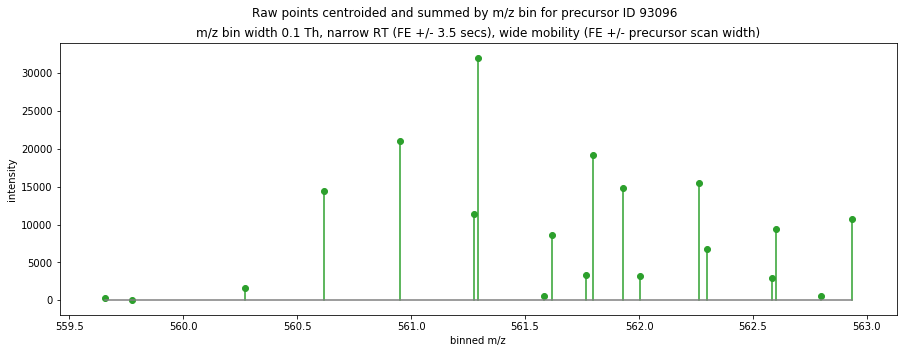

In [110]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms1_peaks_df.mz_centroid, ms1_peaks_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

Trying very small bins, then intensity descent

In [111]:
MS1_MZ_BIN_WIDTH = 1e-5

In [112]:
ms1_bins = np.arange(start=window_mz_lower, stop=window_mz_upper+MS1_MZ_BIN_WIDTH, step=MS1_MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [113]:
# adjust the bins to illustrate the peak splitting issue
# ms1_bins += 0.06

In [114]:
MZ_BIN_COUNT = len(ms1_bins)

In [115]:
MZ_BIN_COUNT

340002

In [116]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms1_mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    ms1_mz_values_array[idx] = []


In [117]:
%%time

# gather the m/z values into bins
for r in zip(fe_raw_points_df.mz, fe_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= window_mz_lower) and (mz <= window_mz_upper): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms1_bins)) # in which bin should this mz go
        ms1_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 395 ms, sys: 3.48 ms, total: 398 ms
Wall time: 405 ms


In [118]:
import peakutils

In [119]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
binned_ms1_l = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(ms1_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms1_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms1_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        binned_ms1_l.append((mz_centroid,summed_intensity))

CPU times: user 82.6 ms, sys: 4.28 ms, total: 86.9 ms
Wall time: 84.2 ms


In [120]:
binned_ms1_df = pd.DataFrame(binned_ms1_l, columns=['mz_centroid','summed_intensity'])

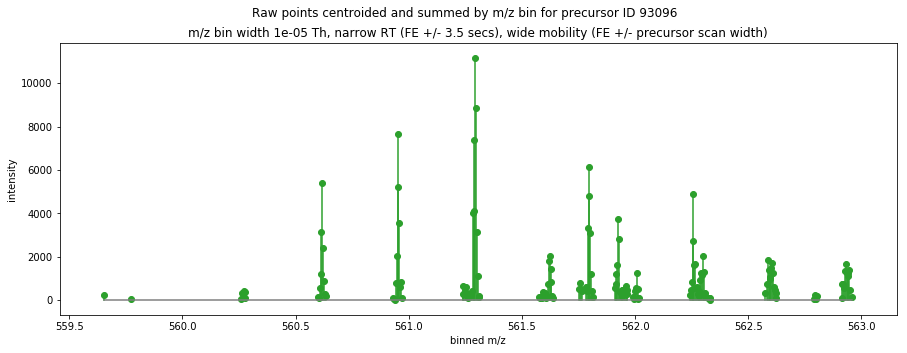

In [121]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(binned_ms1_df.mz_centroid, binned_ms1_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

Zooming in on a peak region

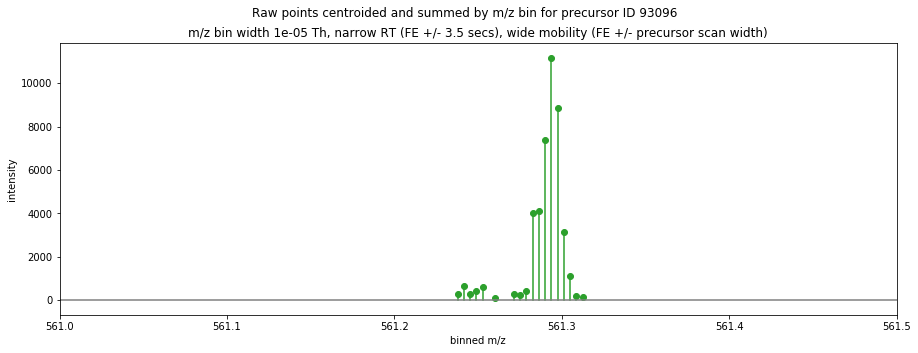

In [123]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(binned_ms1_df.mz_centroid, binned_ms1_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim([561.0,561.5])
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

In [124]:
raw_scratch_df = binned_ms1_df.copy() # take a copy because we're going to delete stuff

In [125]:
len(raw_scratch_df)

155

In [126]:
MZ_DELTA = 0.01

In [127]:
ms1_peaks_l = []
while len(raw_scratch_df) > 0:
    # find the most intense point
    peak_df = raw_scratch_df.loc[raw_scratch_df.summed_intensity.idxmax()]
    peak_mz = peak_df.mz_centroid
    peak_mz_lower = peak_mz - MZ_DELTA
    peak_mz_upper = peak_mz + MZ_DELTA

    # get all the raw points within this m/z region
    peak_raw_points_df = raw_scratch_df[(raw_scratch_df.mz_centroid >= peak_mz_lower) & (raw_scratch_df.mz_centroid <= peak_mz_upper)]
    mz_centroid = peakutils.centroid(peak_raw_points_df.mz_centroid, peak_raw_points_df.summed_intensity)
    summed_intensity = peak_raw_points_df.summed_intensity.sum()
    ms1_peaks_l.append((mz_centroid, summed_intensity))

    # remove the raw points assigned to this peak
    raw_scratch_df = raw_scratch_df[~raw_scratch_df.isin(peak_raw_points_df)].dropna(how = 'all')

In [128]:
ms1_peaks_df = pd.DataFrame(ms1_peaks_l, columns=['mz','intensity'])

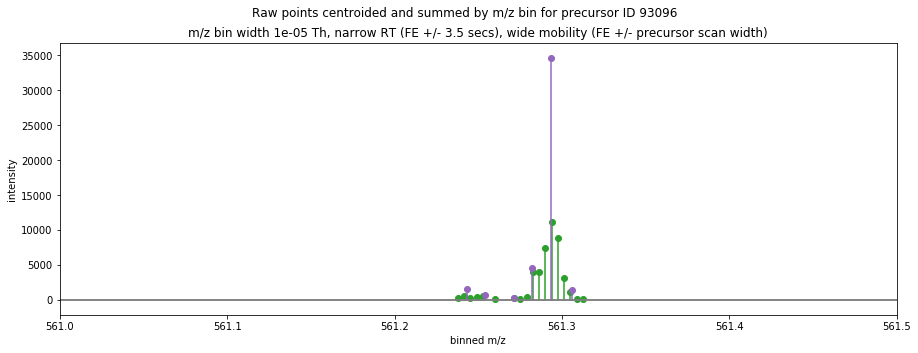

In [129]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(binned_ms1_df.mz_centroid, binned_ms1_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
markerline, stemlines, baseline = ax.stem(ms1_peaks_df.mz, ms1_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[4])
plt.setp(stemlines, 'color', colors[4])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim([561.0,561.5])
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

In [130]:
len(ms1_peaks_df)

51

### Deconvolute the raw (bin-summed, centroided) peaks to find monoisotopic peaks

In [131]:
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.


In [132]:
from ms_deisotope import deconvolute_peaks, averagine, scoring

In [133]:
%%time

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(ms1_peaks_l, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

CPU times: user 30.2 ms, sys: 709 µs, total: 30.9 ms
Wall time: 30.3 ms


In [134]:
peaks_l = []
for peak in deconvoluted_peaks:
    # discard a monoisotopic peak that has either of the first two peaks as placeholders (indicated by intensity of 1)
    if ((len(peak.envelope) >= 3) and (peak.envelope[0][1] > 1) and (peak.envelope[1][1] > 1)):
        peaks_l.append((peak.mz, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise, peak.envelope))
        print("{}\n".format(peak))

deconvoluted_peaks_df = pd.DataFrame(peaks_l, columns=['mz','neutral_mass','intensity','score','SN','envelope'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
deconvoluted_peaks_df['m_plus_h'] = deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=4.713718221225951, area=58495.0, average_mass=1121.5772903192053, charge=2, chosen_for_msms=False, envelope=[(561.2938, 34697.00), (561.7960, 17816.00), (562.2980, 5982.00)], full_width_at_half_max=0.01, index=1|6, intensity=58495.0, most_abundant_mass=1120.5730015872007, mz=561.2942811101578, neutral_mass=1120.5740092867757, score=360.59844987697073, signal_to_noise=19498.333333333332)

DeconvolutedPeak(a_to_a2_ratio=4.713718221225952, area=3720.0, average_mass=1121.6021140576252, charge=2, chosen_for_msms=False, envelope=[(561.3062, 1447.00), (561.8073, 1789.00), (562.3115, 484.00)], full_width_at_half_max=0.01, index=2|7, intensity=3720.0, most_abundant_mass=1121.599959444372, mz=561.3062457710176, neutral_mass=1120.5979386084953, score=72.52796805480573, signal_to_noise=1240.0)

DeconvolutedPeak(a_to_a2_ratio=1.9820930333198612, area=3494.0, average_mass=1679.2941493432031, charge=3, chosen_for_msms=False, envelope=[(560.2697, 1484.00), (560.6048, 844

In [135]:
deconvoluted_peaks_df

,mz,neutral_mass,intensity,score,SN,envelope,m_plus_h
0,561.294281,1120.574009,58495.000000,360.598450,19498.333333,"((561.2938, 34697.00), (561.7960, 17816.00), (...",1121.581309
1,561.306246,1120.597939,3720.000000,72.527968,1240.000000,"((561.3062, 1447.00), (561.8073, 1789.00), (56...",1121.605239
2,560.269706,1677.787289,3494.000000,86.615520,873.500000,"((560.2697, 1484.00), (560.6048, 844.00), (560...",1678.794589
3,560.618600,1678.833970,43671.000000,248.814275,10917.750000,"((560.6175, 13064.00), (560.9531, 19066.00), (...",1679.841270
4,560.631153,1678.871631,1768.000000,45.248150,589.333333,"((560.6306, 524.00), (560.9656, 963.00), (561....",1679.878931
5,560.924513,1679.751708,1872.000000,29.038581,624.000000,"((560.9315, 90.00), (561.2539, 715.00), (561.5...",1680.759008
6,561.243528,1680.708754,3911.000000,68.342809,977.750000,"((561.2435, 1632.00), (561.5773, 254.00), (561...",1681.716054
7,561.622549,1681.845817,8139.835076,132.261204,2890.750000,"((561.6225, 3462.84), (561.9587, 2200.00), (56...",1682.853117
8,561.923774,1682.749493,32598.000000,252.636278,8149.500000,"((561.9252, 9790.00), (562.2582, 11767.00), (5...",1683.756793
9,562.272211,1683.794802,10594.000000,71.909217,3531.333333,"((562.2722, 1466.00), (562.6051, 6163.00), (56...",1684.802102


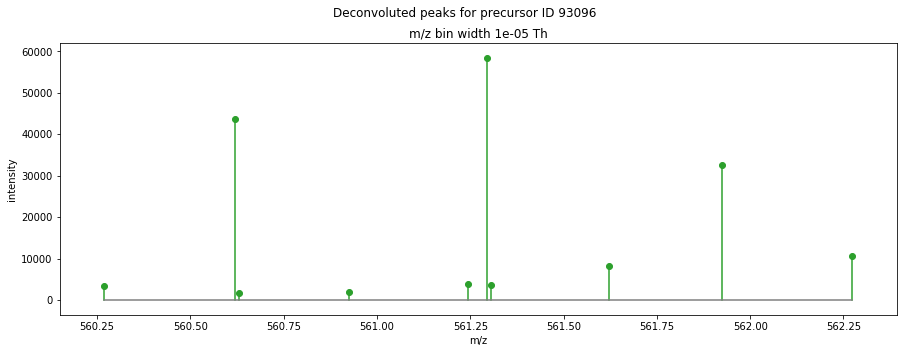

In [136]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th'.format(MS1_MZ_BIN_WIDTH))
plt.show()

### For each monoisotopic peak found, find its apex in RT and mobility

In [454]:
# picking one of the monoisotopic peaks for analysis
DECONVOLUTED_PEAK_IDX = 7
feature_monoisotopic_mz = deconvoluted_peaks_df.iloc[DECONVOLUTED_PEAK_IDX].mz

In [455]:
feature_monoisotopic_mz

561.6225489121304

In [456]:
second_peak_mz = deconvoluted_peaks_df.iloc[DECONVOLUTED_PEAK_IDX].envelope[1][0]

In [457]:
second_peak_mz

561.958697936047

Get the raw points for the monoisotopic peak (constrained by the fragmentation event)

In [458]:
MZ_TOLERANCE_PPM = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [459]:
monoisotopic_mz_ppm_tolerance = feature_monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100
monoisotopic_mz_lower = feature_monoisotopic_mz - monoisotopic_mz_ppm_tolerance
monoisotopic_mz_upper = feature_monoisotopic_mz + monoisotopic_mz_ppm_tolerance

In [460]:
monoisotopic_raw_points_df = fe_raw_points_df[(fe_raw_points_df.mz >= monoisotopic_mz_lower) & (fe_raw_points_df.mz <= monoisotopic_mz_upper)]

In [461]:
monoisotopic_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
2698,28201,561.630090,713,83,3028.407294
2728,28201,561.615143,723,39,3028.407294
2765,28201,561.630090,731,84,3028.407294
2778,28201,561.630090,733,113,3028.407294
2820,28201,561.626353,740,72,3028.407294


### Collapsing the monoisotopic's summed points onto the mobility dimension

In [462]:
scan_df = monoisotopic_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()

In [463]:
centroid_scan = peakutils.centroid(scan_df.scan, scan_df.intensity)

In [464]:
centroid_scan

740.2952259526845

In [465]:
feature_scan_centroid = centroid_scan
feature_scan_lower = window_df.ScanNumBegin
feature_scan_upper = window_df.ScanNumEnd

In [466]:
feature_scan_centroid, feature_scan_lower, feature_scan_upper

(740.2952259526845, 732.0, 757.0)

In [467]:
curve_fit = False
try:
    g_param = peakutils.peak.gaussian_fit(scan_df.scan, scan_df.intensity, center_only=False)
    curve_fit = True
    print(g_param)
except:
    print("could not fit a curve to this data")       


[224.0787497  740.20685703  17.47910121]


In [468]:
peakutils.peak.gaussian_fit(scan_df.scan, scan_df.intensity, center_only=True)

740.2068570301852

In [469]:
g = peakutils.peak.gaussian(scan_df.scan, g_param[0], g_param[1], g_param[2])

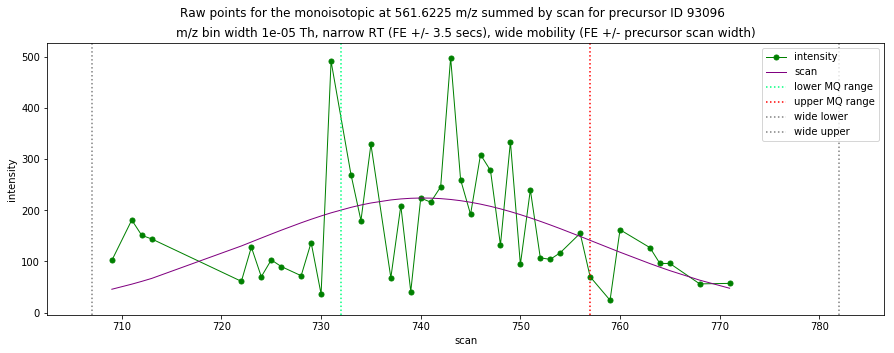

In [470]:
f, ax = plt.subplots()
ax.plot(scan_df.scan, scan_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
ax.plot(scan_df.scan, g, marker='', color='purple', linestyle='-', linewidth=1, ms=5)
plt.axvline(x=window_df.ScanNumBegin, linestyle=':', color='springgreen', label='lower MQ range')
plt.axvline(x=window_df.ScanNumEnd, linestyle=':', color='red', label='upper MQ range')
plt.axvline(x=wide_scan_lower, linestyle=':', color='gray', label='wide lower')
plt.axvline(x=wide_scan_upper, linestyle=':', color='gray', label='wide upper')
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points for the monoisotopic at {:.4f} m/z summed by scan for precursor ID {}'.format(feature_monoisotopic_mz, precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.margins(0.06)
plt.show()

### In the RT dimension, look wider to find the apex of the peak closest to the fragmentation event

In [471]:
wide_rt_monoisotopic_raw_points_df = ms1_raw_points_df[(ms1_raw_points_df.mz >= monoisotopic_mz_lower) & (ms1_raw_points_df.mz <= monoisotopic_mz_upper)]

In [472]:
len(wide_rt_monoisotopic_raw_points_df)

225

In [473]:
rt_df = wide_rt_monoisotopic_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()

In [474]:
rt_df.head()

,frame_id,retention_time_secs,intensity
0,27970,3003.582723,165
1,27981,3004.765302,79
2,28102,3017.768904,259
3,28113,3018.950981,711
4,28124,3020.131311,757


In [475]:
peaks_threshold = 0.3
peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
if len(peaks_idx) == 0:
    peaks_threshold -= 0.1
    peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
peaks_df = rt_df.iloc[peaks_idx].copy()

In [476]:
peaks_df

,frame_id,retention_time_secs,intensity
7,28157,3023.680061,2014


In [477]:
peaks_df['fragmentation_rt_delta'] = abs(window_df.retention_time_secs - peaks_df.retention_time_secs)

In [478]:
peaks_df

,frame_id,retention_time_secs,intensity,fragmentation_rt_delta
7,28157,3023.680061,2014,7.406549


In [479]:
# get the peak closest to the fragmentation event
peaks_df.loc[peaks_df.fragmentation_rt_delta.idxmin()]

frame_id                  28157.000000
retention_time_secs        3023.680061
intensity                  2014.000000
fragmentation_rt_delta        7.406549
Name: 7, dtype: float64

In [480]:
# index of the closest peak
peak_idx = peaks_df.fragmentation_rt_delta.idxmin()
peak_idx

7

In [481]:
feature_rt_apex = peaks_df.loc[peak_idx].retention_time_secs

In [482]:
feature_rt_apex

3023.6800608900726

In [483]:
valleys_idx = peakutils.indexes(-rt_df.intensity.values, thres=0.6, min_dist=RT_BASE_PEAK_WIDTH_SECS/20)
valleys_df = rt_df.iloc[valleys_idx].copy()

In [484]:
valleys_df

,frame_id,retention_time_secs,intensity
1,27981,3004.765302,79
20,28300,3039.035626,75


In [485]:
valleys_idx

array([ 1, 20])

In [486]:
# find the closest valley above the peak
if max(valleys_idx) > peak_idx:
    valley_idx_above = valleys_idx[valleys_idx > peak_idx].min()
else:
    valley_idx_above = -1

In [487]:
# find the closest valley below the peak
if min(valleys_idx) < peak_idx:
    valley_idx_below = valleys_idx[valleys_idx < peak_idx].max()
else:
    valley_idx_below = -1

In [488]:
print("{},{}".format(valley_idx_below, valley_idx_above))

1,20


In [489]:
feature_rt_base_lower = valleys_df.loc[valley_idx_below].retention_time_secs
feature_rt_base_upper = valleys_df.loc[valley_idx_above].retention_time_secs

In [490]:
feature_rt_base_lower, feature_rt_base_upper

(3004.765301705537, 3039.035625568906)

In [491]:
curve_fit = False
try:
    g_param = peakutils.peak.gaussian_fit(rt_df.retention_time_secs, rt_df.intensity, center_only=False)
    g = peakutils.peak.gaussian(rt_df.retention_time_secs, g_param[0], g_param[1], g_param[2])
    curve_fit = True
    print(g_param)
except:
    print("could not fit a curve to this data")       


[1706.84633065 3026.5226441     6.14814749]


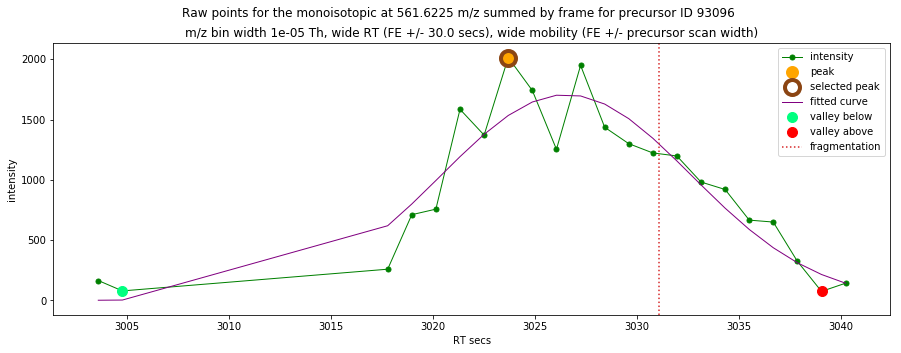

In [492]:
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
ax.plot(peaks_df.retention_time_secs, peaks_df.intensity, marker='o', color='orange', linestyle='', markeredgewidth=3, ms=10, label='peak')
ax.plot(peaks_df.loc[peak_idx].retention_time_secs, peaks_df.loc[peak_idx].intensity, marker='o', markerfacecolor='none', markeredgecolor='saddlebrown', linestyle='', markeredgewidth=4, ms=15, label='selected peak')
ax.plot(rt_df.retention_time_secs, g, marker='', color='purple', linestyle='-', linewidth=1, ms=5, label='fitted curve')
if valley_idx_below != -1:
    ax.plot(valleys_df.loc[valley_idx_below].retention_time_secs, valleys_df.loc[valley_idx_below].intensity, marker='o', color='springgreen', linestyle='', markeredgewidth=1, ms=10, label='valley below')
if valley_idx_above != -1:
    ax.plot(valleys_df.loc[valley_idx_above].retention_time_secs, valleys_df.loc[valley_idx_above].intensity, marker='o', color='red', linestyle='', markeredgewidth=1, ms=10, label='valley above')
plt.axvline(x=window_df.retention_time_secs, linestyle=':', color='tab:red', label='fragmentation')
plt.legend(loc='best')
plt.xlabel('RT secs')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points for the monoisotopic at {:.4f} m/z summed by frame for precursor ID {}'.format(feature_monoisotopic_mz, precursor_id))
plt.title('m/z bin width {} Th, wide RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MS1_MZ_BIN_WIDTH, RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()

### Having extracted the MS1 feature characteristics, find all isolation windows that overlap with it

In [191]:
feature_monoisotopic_mz, feature_rt_apex, feature_rt_base_lower, feature_rt_base_upper, feature_scan_centroid, feature_scan_lower, feature_scan_upper

(561.2942811101578,
 3029.5865252545436,
 3023.6800608900726,
 3036.670329740068,
 737.395761197364,
 732.0,
 757.0)

In [192]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [193]:
# add-in the retention time for the isolation windows and filter out the windows not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])

In [194]:
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)

In [195]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
198004,27938,266,291,1076.631729,3.000000,92011,3000.14099,1075.131729,1078.131729
198005,27938,328,353,1029.087583,3.000000,92012,3000.14099,1027.587583,1030.587583
198006,27938,381,406,764.846135,2.648461,92025,3000.14099,763.521905,766.170366
198007,27938,451,476,814.369146,3.000000,92026,3000.14099,812.869146,815.869146
198008,27938,501,526,750.768344,2.507683,92038,3000.14099,749.514503,752.022186


In [196]:
# define the visualisation window
visualisation_mz_upper = feature_monoisotopic_mz + 3
visualisation_mz_lower = feature_monoisotopic_mz - 3
visualisation_scan_upper = feature_scan_upper + 20
visualisation_scan_lower = feature_scan_lower - 20
visualisation_rt_upper = feature_rt_base_upper
visualisation_rt_lower = feature_rt_base_lower

In [197]:
# find the isolation windows visible in the visualisation window
indexes = isolation_window_df.index[
                        (
                            ((isolation_window_df.mz_lower >= visualisation_mz_lower) &
                             (isolation_window_df.mz_lower <= visualisation_mz_upper)) |
                            ((isolation_window_df.mz_upper >= visualisation_mz_lower) &
                            (isolation_window_df.mz_upper <= visualisation_mz_upper))
                        ) &
                        (
                            ((isolation_window_df.ScanNumBegin >= visualisation_scan_lower) &
                             (isolation_window_df.ScanNumBegin <= visualisation_scan_upper)) |
                            ((isolation_window_df.ScanNumEnd >= visualisation_scan_lower) &
                            (isolation_window_df.ScanNumEnd <= visualisation_scan_upper))
                        ) &
                        (isolation_window_df.retention_time_secs >= visualisation_rt_lower) &
                        (isolation_window_df.retention_time_secs <= visualisation_rt_upper)
                       ]
isolation_windows_in_visualisation_area_df = isolation_window_df.loc[indexes]

In [198]:
isolation_windows_in_visualisation_area_df

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
199831,28159,717,742,564.569941,2.0,92865,3023.892069,563.569941,565.569941
199839,28160,717,742,564.569941,2.0,92865,3023.999992,563.569941,565.569941
200360,28220,732,757,561.289356,2.0,93096,3030.444369,560.289356,562.289356
200400,28226,732,757,561.289356,2.0,93096,3031.086610,560.289356,562.289356


In [199]:
feature_monoisotopic_mz

561.2942811101578

In [200]:
feature_rt_base_lower, feature_rt_base_upper

(3023.6800608900726, 3036.670329740068)

In [201]:
feature_scan_centroid

737.395761197364

In [202]:
# find the isolation windows overlapping the feature's mono or second peak, plus scan and RT
indexes = isolation_window_df.index[
                            (((isolation_window_df.mz_upper >= feature_monoisotopic_mz) & (isolation_window_df.mz_lower <= feature_monoisotopic_mz)) |
                            ((isolation_window_df.mz_upper >= second_peak_mz) & (isolation_window_df.mz_lower <= second_peak_mz))) &
                            (isolation_window_df.ScanNumEnd >= feature_scan_centroid) &
                            (isolation_window_df.ScanNumBegin <= feature_scan_centroid) &
                            (isolation_window_df.retention_time_secs >= feature_rt_base_lower) &
                            (isolation_window_df.retention_time_secs <= feature_rt_base_upper)
                       ]
isolation_windows_overlapping_feature_df = isolation_window_df.loc[indexes]

In [203]:
isolation_windows_overlapping_feature_df

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
200360,28220,732,757,561.289356,2.0,93096,3030.444369,560.289356,562.289356
200400,28226,732,757,561.289356,2.0,93096,3031.086610,560.289356,562.289356


In [204]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

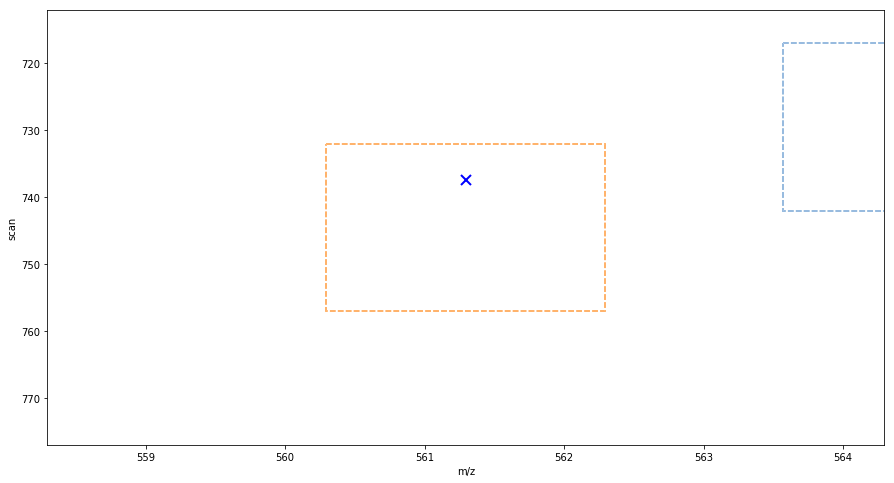

In [205]:
import matplotlib.patches as patches

f, ax1 = plt.subplots()

# add the mono peak's centroid
plt.plot(feature_monoisotopic_mz, feature_scan_centroid, 'bx', ms=10, mew=2, label='centroid')

# add isolation windows matched
for idx in range(len(isolation_windows_in_visualisation_area_df)):
    window = isolation_windows_in_visualisation_area_df.iloc[idx]
    drift_range = window.ScanNumEnd - window.ScanNumBegin
    mz_range = window.mz_upper - window.mz_lower
    isolation_window_rect = patches.Rectangle((window.mz_lower,window.ScanNumBegin),mz_range,drift_range,linewidth=1.5,linestyle='--',edgecolor=tableau20[idx%len(tableau20)],facecolor='none')
    ax1.add_patch(isolation_window_rect)
    text_style = dict(size=12, color=tableau20[idx%len(tableau20)])
#     ax1.text(window.mz_lower, window.ScanNumBegin-0.5, window.frame_precursor, **text_style)
    
f.set_figheight(8)
f.set_figwidth(15)
# plt.gca().invert_yaxis()
plt.gca().set_xlim([visualisation_mz_lower,visualisation_mz_upper])
plt.gca().set_ylim([visualisation_scan_upper,visualisation_scan_lower])
plt.xlabel('m/z')
plt.ylabel('scan')
# plt.legend(loc='best')
plt.margins(0.02)
# plt.suptitle("Feature {} and isolation window overlap, RT={} to {}".format(feature_id_of_interest, round(feature.feature_start_rt,1), round(feature.feature_end_rt,1)))
# plt.title('{}'.format(feature_list_filename))
plt.show()

### Extract all the raw ms2 points from the overlapping isolation windows

In [206]:
# get the ms2 frame IDs
ms2_frame_ids = tuple(ms2_frame_properties_df.astype(int).values[:,0])


In [208]:
ms2_frame_properties_df[ms2_frame_properties_df.frame_id == 28220]

,frame_id,retention_time_secs
257,28220,3030.444369


In [209]:
isolation_window_scan_lower = int(isolation_windows_overlapping_feature_df.iloc[0].ScanNumBegin)
isolation_window_scan_upper = int(isolation_windows_overlapping_feature_df.iloc[0].ScanNumEnd)
isolation_window_frame_id = int(isolation_windows_overlapping_feature_df.iloc[0].Frame)

In [210]:
isolation_window_scan_lower, isolation_window_scan_upper, isolation_window_frame_id

(732, 757, 28220)

In [211]:
# get the raw ms2 points from the fragmentation frame within the scan constraints
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms2_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_id == {} and scan >= {} and scan <= {}".format(isolation_window_frame_id,isolation_window_scan_lower,isolation_window_scan_upper), db_conn)
db_conn.close()

In [212]:
len(ms2_raw_points_df)

266

In [213]:
MS2_MZ_MAX = ms2_raw_points_df.mz.max()
MS2_MZ_MIN = ms2_raw_points_df.mz.min()

In [214]:
MS2_MZ_MIN, MS2_MZ_MAX

(140.9407917685214, 1690.0618217409456)

In [215]:
MS2_MZ_BIN_WIDTH = 1e-5

In [216]:
ms2_bins = np.arange(start=MS2_MZ_MIN, stop=MS2_MZ_MAX+MS2_MZ_BIN_WIDTH, step=MS2_MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [217]:
MS2_MZ_BIN_COUNT = len(ms2_bins)

In [218]:
MS2_MZ_BIN_COUNT

154912104

In [219]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms2_mz_values_array = np.empty(MS2_MZ_BIN_COUNT, dtype=np.object)
for idx in range(MS2_MZ_BIN_COUNT):
    ms2_mz_values_array[idx] = []


In [220]:
%%time

# gather the m/z values into bins
for r in zip(ms2_raw_points_df.mz, ms2_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= MS2_MZ_MIN) and (mz <= MS2_MZ_MAX): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms2_bins)) # in which bin should this mz go
        ms2_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 33.1 s, sys: 2.98 s, total: 36.1 s
Wall time: 38.8 s


In [221]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
binned_ms2_l = []
for bin_idx in range(MS2_MZ_BIN_COUNT):
    if len(ms2_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms2_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms2_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        binned_ms2_l.append((mz_centroid,summed_intensity))

CPU times: user 39.1 s, sys: 12.8 s, total: 51.9 s
Wall time: 55.6 s


In [222]:
len(binned_ms2_l)

253

In [223]:
binned_ms2_df = pd.DataFrame(binned_ms2_l, columns=['mz_centroid','summed_intensity'])

now do intensity descent to find the peaks

In [224]:
raw_scratch_df = binned_ms2_df.copy() # take a copy because we're going to delete stuff

In [225]:
len(raw_scratch_df)

253

In [226]:
MZ_DELTA = 0.01

In [227]:
ms2_peaks_l = []
while len(raw_scratch_df) > 0:
    # find the most intense point
    peak_df = raw_scratch_df.loc[raw_scratch_df.summed_intensity.idxmax()]
    peak_mz = peak_df.mz_centroid
    peak_mz_lower = peak_mz - MZ_DELTA
    peak_mz_upper = peak_mz + MZ_DELTA

    # get all the raw points within this m/z region
    peak_raw_points_df = raw_scratch_df[(raw_scratch_df.mz_centroid >= peak_mz_lower) & (raw_scratch_df.mz_centroid <= peak_mz_upper)]
    mz_centroid = peakutils.centroid(peak_raw_points_df.mz_centroid, peak_raw_points_df.summed_intensity)
    summed_intensity = peak_raw_points_df.summed_intensity.sum()
    ms2_peaks_l.append((mz_centroid, summed_intensity))

    # remove the raw points assigned to this peak
    raw_scratch_df = raw_scratch_df[~raw_scratch_df.isin(peak_raw_points_df)].dropna(how = 'all')

In [228]:
ms2_peaks_df = pd.DataFrame(ms2_peaks_l, columns=['mz','intensity'])

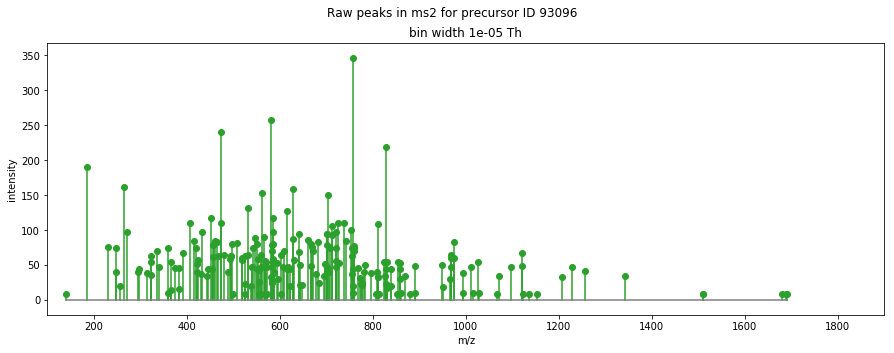

In [229]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms2_peaks_df.mz, ms2_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.suptitle('Raw peaks in ms2 for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MS2_MZ_BIN_WIDTH))
plt.show()

In [230]:
%%time

# ms2_deconvoluted_peaks, _ = deconvolute_peaks(ms2_peaks, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)
ms2_deconvoluted_peaks, _ = deconvolute_peaks(ms2_peaks_l, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

CPU times: user 149 ms, sys: 7.06 ms, total: 156 ms
Wall time: 185 ms


In [231]:
ms2_peaks_l = []
for peak in ms2_deconvoluted_peaks:
    # discard a monoisotopic peak that has a second isotope with intensity of 1 (rubbish value)
    if ((len(peak.envelope) > 1) and (peak.envelope[1][1] > 1)):
        ms2_peaks_l.append((peak.mz, peak.charge, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
        print("{}\n".format(peak))

ms2_deconvoluted_peaks_df = pd.DataFrame(ms2_peaks_l, columns=['mz','charge','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
ms2_deconvoluted_peaks_df['m_plus_h'] = ms2_deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=0.0, area=163.0, average_mass=452.72468899240306, charge=1, chosen_for_msms=False, envelope=[(453.2348, 118.00), (454.2292, 45.00)], full_width_at_half_max=0.01, index=2|2, intensity=163.0, most_abundant_mass=452.2274838828139, mz=453.2347603495839, neutral_mass=452.2274838828139, score=12.943183655781272, signal_to_noise=81.5)

DeconvolutedPeak(a_to_a2_ratio=0.0, area=351.0, average_mass=472.7996794440993, charge=1, chosen_for_msms=False, envelope=[(473.3067, 241.00), (474.3072, 110.00)], full_width_at_half_max=0.01, index=3|3, intensity=351.0, most_abundant_mass=472.2994222760411, mz=473.30669874281114, neutral_mass=472.2994222760411, score=20.06399451705368, signal_to_noise=175.5)

DeconvolutedPeak(a_to_a2_ratio=16.387816788256035, area=140.0, average_mass=566.7679995472934, charge=1, chosen_for_msms=False, envelope=[(567.2718, 91.00), (568.2787, 49.00), (569.2771, 1.00)], full_width_at_half_max=0.01, index=4|4, intensity=140.0, most_abundant_mass=566.

In [232]:
len(ms2_deconvoluted_peaks_df)

13

In [233]:
ms2_deconvoluted_peaks_df.mz.min(),ms2_deconvoluted_peaks_df.mz.max()

(453.2347603495839, 829.4793187382089)

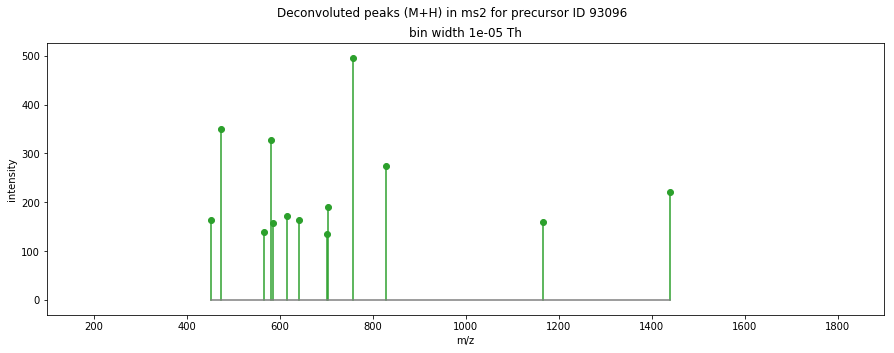

In [234]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms2_deconvoluted_peaks_df.m_plus_h, ms2_deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks (M+H) in ms2 for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MS2_MZ_BIN_WIDTH))
plt.show()

In [235]:
ms2_deconvoluted_peaks_df[['mz','intensity']].to_csv('/Users/darylwilding-mcbride/Downloads/my_ms2_for_precursor_{}.csv'.format(precursor_id))

In [236]:
# find the top peaks by intensity
ms2_deconvoluted_peaks_df.sort_values(by=['intensity'], ascending=False).head(10)

,mz,charge,neutral_mass,intensity,score,SN,m_plus_h
9,758.366209,1,757.358933,496.0,22.333858,165.333333,758.366233
1,473.306699,1,472.299422,351.0,20.063995,175.500000,473.306722
3,582.268387,1,581.261110,328.0,20.967723,164.000000,582.268410
10,829.479319,1,828.472042,274.0,15.336261,137.000000,829.479342
12,719.847258,2,1437.679963,221.0,11.708899,73.666667,1438.687263
8,704.367288,1,703.360012,190.0,14.884495,95.000000,704.367312
5,615.292955,1,614.285678,172.0,15.431943,86.000000,615.292978
6,641.301841,1,640.294565,164.0,12.630521,82.000000,641.301865
0,453.234760,1,452.227484,163.0,12.943184,81.500000,453.234784
11,584.259428,2,1166.504304,160.0,13.848164,80.000000,1167.511604


### Compare with the ms2 spectra recorded by MaxQuant in the APL files

In [237]:
pasef_msms_scans_df = pd.read_csv(PASEF_MSMS_SCANS_FILENAME, sep='\t')

In [238]:
pasef_msms_scans_df.head()

,Raw file,Frame,Precursor,IsolationMz,IsolationWidth,ScanNumBegin,ScanNumEnd,CollisionEnergy,Index
0,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,1,742.744835,2.427448,507,532,36.96,0
1,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,2,709.235759,2.092358,549,574,36.96,1
2,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,3,594.235088,2.000000,602,627,36.96,2
3,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,4,503.527768,2.000000,643,668,36.96,3
4,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,5,552.063870,2.000000,684,709,31.92,4


In [239]:
pasef_msms_scans_df[pasef_msms_scans_df.Index == 324135]

,Raw file,Frame,Precursor,IsolationMz,IsolationWidth,ScanNumBegin,ScanNumEnd,CollisionEnergy,Index
324135,HeLa_20KInt_2KIT_Slot1-46_01_1179,41474,153421,860.444362,3.0,462,487,42.0,324135


In [240]:
mq_index = pasef_msms_scans_df[pasef_msms_scans_df.Precursor == precursor_id].index.values[0]

In [241]:
mq_index

200360

In [242]:
MIN_ISOTOPE_CORRELATION = 0.9

allpeptides_df = pd.read_csv(ALLPEPTIDES_FILENAME, sep='\t')
allpeptides_df.rename(columns={'Number of isotopic peaks':'isotope_count', 'm/z':'mz', 'Number of data points':'number_data_points', 'Intensity':'intensity', 'Ion mobility index':'scan', 'Ion mobility index length':'scan_length', 'Ion mobility index length (FWHM)':'scan_length_fwhm', 'Retention time':'rt', 'Retention length':'rt_length', 'Retention length (FWHM)':'rt_length_fwhm', 'Charge':'charge_state', 'Number of pasef MS/MS':'number_pasef_ms2_ids', 'Pasef MS/MS IDs':'pasef_msms_ids', 'MS/MS scan number':'msms_scan_number', 'Isotope correlation':'isotope_correlation'}, inplace=True)
# allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull() & (allpeptides_df.isotope_correlation >= MIN_ISOTOPE_CORRELATION) & (allpeptides_df.rt >= RT_LIMIT_LOWER) & (allpeptides_df.rt <= RT_LIMIT_UPPER)].copy()
allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull() & allpeptides_df.pasef_msms_ids.notnull() & (allpeptides_df.rt >= RT_LIMIT_LOWER) & (allpeptides_df.rt <= RT_LIMIT_UPPER)].copy()
allpeptides_df.msms_scan_number = allpeptides_df.msms_scan_number.apply(lambda x: int(x))

In [243]:
allpeptides_df.head()

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Min frame index,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number
141,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,323.20532,644.39609,24081.618842,479,11,2,0.982737,0.396088,...,2950,2960,777,24,18,7420.9,NaN,5,236674;236685;236717;236811;236822,1672
159,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,331.18456,660.35457,24407.776620,854,17,2,0.978261,0.354574,...,2777,2793,783,18,15,6835.4,NaN,4,220645;220654;220663;220672,1925
176,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,335.69526,669.37597,24427.020136,1120,14,2,0.984496,0.375970,...,2713,2726,789,30,18,12121.0,NaN,9,214253;214263;214282;214292;214312;214321;2143...,2046
199,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,321.69816,641.38176,24723.651407,2836,18,3,0.999085,0.381760,...,2909,2926,801,30,21,54187.0,NaN,8,232746;232754;232794;232803;232812;232821;2328...,1625
256,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,310.21078,618.40700,24448.182101,666,12,2,0.989944,0.406997,...,2960,2971,807,24,15,8903.0,NaN,12,237930;237941;237996;238007;238018;238156;2381...,1391


In [244]:
allpeptides_df['pasef_msms_ids_list'] = allpeptides_df.pasef_msms_ids.str.split(";").apply(lambda x: [int(i) for i in x])

In [245]:
allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: 324135 in x)]

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number,pasef_msms_ids_list


In [246]:
allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: mq_index in x)]

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number,pasef_msms_ids_list
102604,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,560.618,1678.8322,24125.094868,5252,23,3,0.963331,0.832163,...,2574,750,54,30,61394.0,NaN,6,199668;199676;199737;199746;200360;200400,64647,"[199668, 199676, 199737, 199746, 200360, 200400]"


In [247]:
msms_scan_number = int(allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: mq_index in x)].msms_scan_number)

In [248]:
msms_scan_number

64647

In [249]:
# load the ms2 spectra from the APL (hand-pasted into a file for now)
apl_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/allSpectra_5_apl_index_66893.txt', header=None, names=['mz','intensity'], sep='\t')

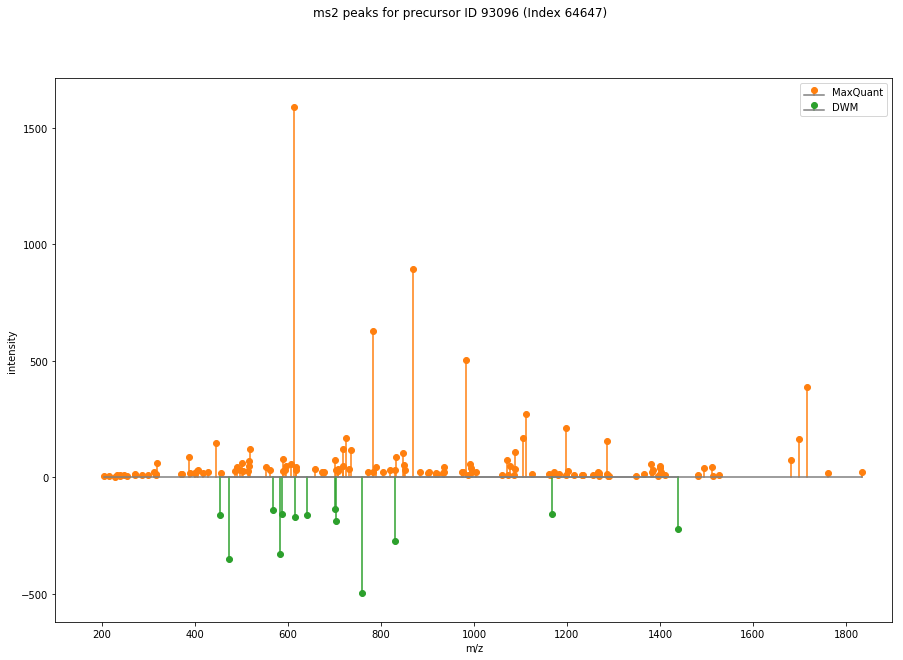

In [250]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(apl_df.mz, apl_df.intensity, 'g', label='MaxQuant')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])
markerline, stemlines, baseline = ax.stem(ms2_deconvoluted_peaks_df.m_plus_h, -ms2_deconvoluted_peaks_df.intensity, 'g', label='DWM')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(10)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.legend(loc='best')
plt.suptitle('ms2 peaks for precursor ID {} (Index {})'.format(precursor_id, msms_scan_number))
plt.show()

### Compare with the real identification from MaxQuant

In [251]:
# check the error from the identification
evidence_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/evidence.txt', sep='\t')